# Downstram Analysis of the results of the Deconvolution: Using All the samples

In [1]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os
import pandas as pd
import seaborn as sns

import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
results_folder = 'Cell2Location/results/'
r = {'run_name': 'LocationModelLinearDependentWMultiExperiment_14experiments_40clusters_20654locations_4306genes'}

# defining useful function
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [3]:
sp_data_file = results_folder +r['run_name']+'/sp.h5ad'

adata_vis = anndata.read(sp_data_file)

We have to remove our low quality sample. 

In [4]:
adata_vis.obs

in_tissue  array_row  array_col  \
spot_id                                                                        
Count_SN048_A121573_Rep1_AAACAAGTATCTCCCA-1          1         50        102   
Count_SN048_A121573_Rep1_AAACACCAATAACTGC-1          1         59         19   
Count_SN048_A121573_Rep1_AAACATTTCCCGGATT-1          1         61         97   
Count_SN048_A121573_Rep1_AAACCCGAACGAAATC-1          1         45        115   
Count_SN048_A121573_Rep1_AAACCGGGTAGGTACC-1          1         42         28   
...                                                ...        ...        ...   
SN123_A938797_Rep1_TTGTTAGCAAATTCGA-1                1         22         42   
SN123_A938797_Rep1_TTGTTCAGTGTGCTAC-1                1         24         64   
SN123_A938797_Rep1_TTGTTGTGTGTCAAGA-1                1         31         77   
SN123_A938797_Rep1_TTGTTTCACATCCAGG-1                1         58         42   
SN123_A938797_Rep1_TTGTTTCCATACAACT-1                1         45         27   

                                                               sample  \
spot_id                                                                 
Count_SN048_A121573_Rep1_AAACAAGTATCTCCCA-1  Count_SN048_A121573_Rep1   
Count_SN048_A121573_Rep1_AAACACCAATAACTGC-1  Count_SN048_A121573_Rep1   
Count_SN048_A121573_Rep1_AAACATTTCCCGGATT-1  Count_SN048_A121573_Rep1   
Count_SN048_A121573_Rep1_AAACCCGAACGAAATC-1  Count_SN048_A121573_Rep1   
Count_SN048_A121573_Rep1_AAACCGGGTAGGTACC-1  Count_SN048_A121573_Rep1   
...                                                               ...   
SN123_A938797_Rep1_TTGTTAGCAAATTCGA-1              SN123_A938797_Rep1   
SN123_A938797_Rep1_TTGTTCAGTGTGCTAC-1              SN123_A938797_Rep1   
SN123_A938797_Rep1_TTGTTGTGTGTCAAGA-1              SN123_A938797_Rep1   
SN123_A938797_Rep1_TTGTTTCACATCCAGG-1              SN123_A938797_Rep1   
SN123_A938797_Rep1_TTGTTTCCATACAACT-1              SN123_A938797_Rep1   

                                             n_genes_by_counts  \
spot_id                                                          
Count_SN048_A121573_Rep1_AAACAAGTATCTCCCA-1               5341   
Count_SN048_A121573_Rep1_AAACACCAATAACTGC-1               5674   
Count_SN048_A121573_Rep1_AAACATTTCCCGGATT-1               3170   
Count_SN048_A121573_Rep1_AAACCCGAACGAAATC-1               6756   
Count_SN048_A121573_Rep1_AAACCGGGTAGGTACC-1               4295   
...                                                        ...   
SN123_A938797_Rep1_TTGTTAGCAAATTCGA-1                     2339   
SN123_A938797_Rep1_TTGTTCAGTGTGCTAC-1                     3280   
SN123_A938797_Rep1_TTGTTGTGTGTCAAGA-1                     4068   
SN123_A938797_Rep1_TTGTTTCACATCCAGG-1                     3365   
SN123_A938797_Rep1_TTGTTTCCATACAACT-1                     2805   

                                             log1p_n_genes_by_counts  \
spot_id                                                                
Count_SN048_A121573_Rep1_AAACAAGTATCTCCCA-1                 8.583355   
Count_SN048_A121573_Rep1_AAACACCAATAACTGC-1                 8.643826   
Count_SN048_A121573_Rep1_AAACATTTCCCGGATT-1                 8.061802   
Count_SN048_A121573_Rep1_AAACCCGAACGAAATC-1                 8.818334   
Count_SN048_A121573_Rep1_AAACCGGGTAGGTACC-1                 8.365440   
...                                                              ...   
SN123_A938797_Rep1_TTGTTAGCAAATTCGA-1                       7.757906   
SN123_A938797_Rep1_TTGTTCAGTGTGCTAC-1                       8.095904   
SN123_A938797_Rep1_TTGTTGTGTGTCAAGA-1                       8.311153   
SN123_A938797_Rep1_TTGTTTCACATCCAGG-1                       8.121480   
SN123_A938797_Rep1_TTGTTTCCATACAACT-1                       7.939515   

                                             total_counts  log1p_total_counts  \
spot_id                                                                         
Count_SN048_A121573_Rep1_AAACAAGTATCTCCCA-1       17364.0            9.762212   
Count_SN048_A12

# 1.- Clustering based on cell abundances

### Low Resolution = 0.25 (Few clusters)

In [5]:
sample_type = 'q05_nUMI_factors'
col_ind = [sample_type in i for i in adata_vis.obs.columns.tolist()]
adata_vis.obsm[sample_type] = adata_vis.obs.loc[:,col_ind].values

# compute KNN using the cell2location output
sc.pp.neighbors(adata_vis, use_rep=sample_type,
                n_neighbors = 30)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=0.25)

# add region as categorical variable
adata_vis.obs["region_cluster_025"] = adata_vis.obs["leiden"]
adata_vis.obs["region_cluster_025"] =  adata_vis.obs["region_cluster_025"].astype("category")

In [6]:
sc.tl.umap(adata_vis, min_dist = 0.75, spread = 1)

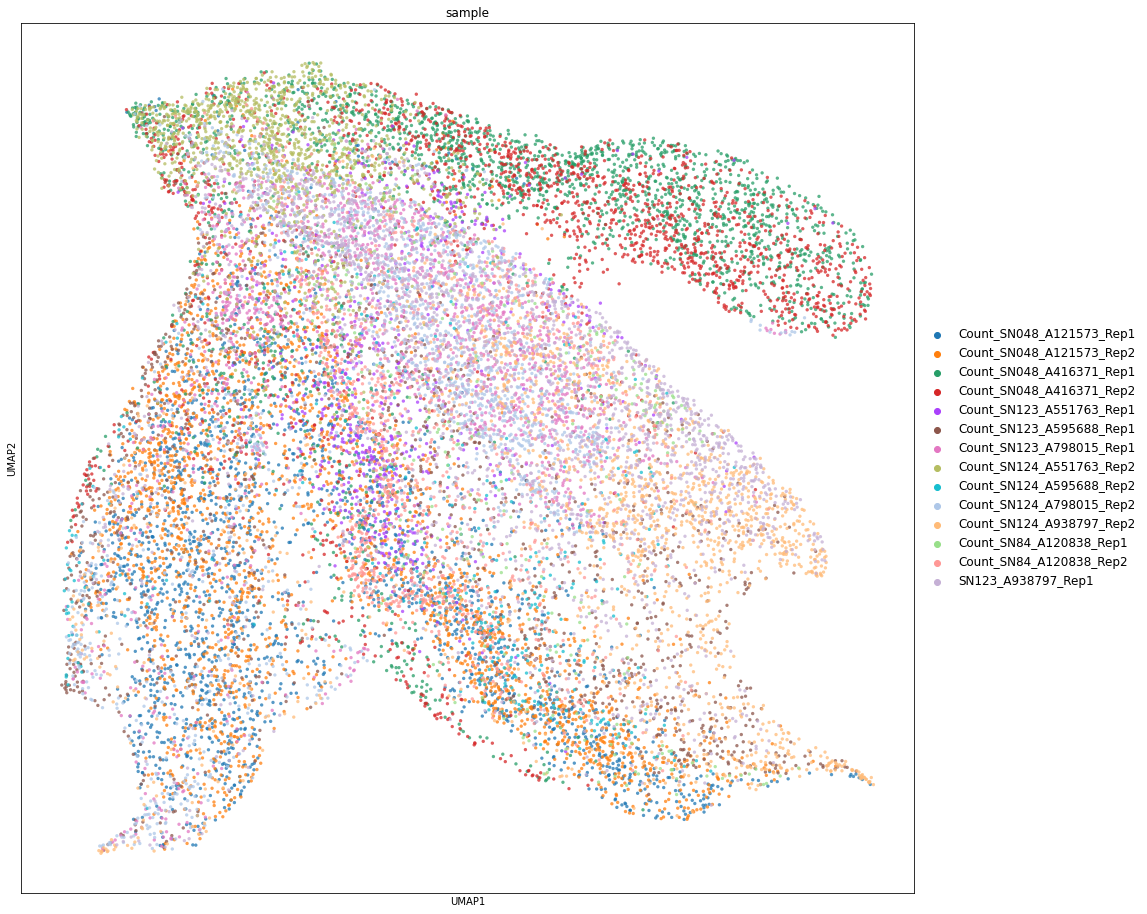

In [7]:
with mpl.rc_context({'figure.figsize': (16, 16)}):
    sc.pl.umap(adata_vis, color=['sample'], size=45,
               color_map = 'RdPu',
               legend_fontsize=12, alpha=0.75)

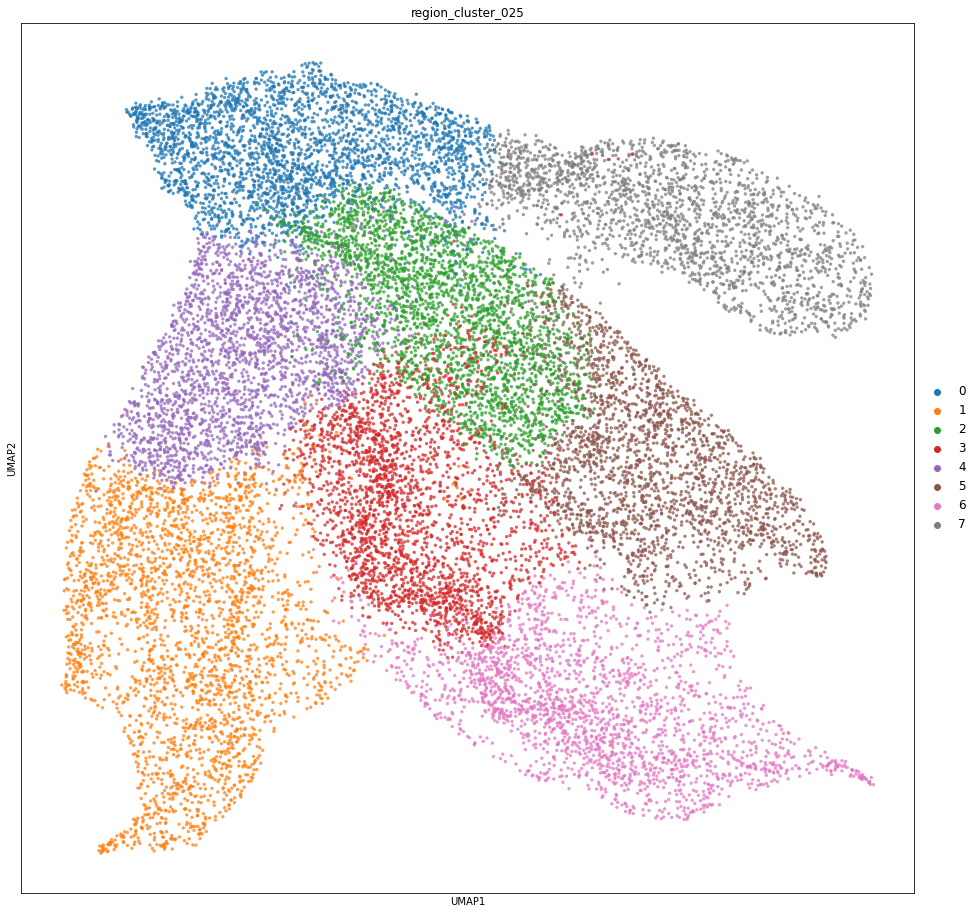

In [8]:
with mpl.rc_context({'figure.figsize': (16, 16)}):
    sc.pl.umap(adata_vis, color=['region_cluster_025'], size=45,
               color_map = 'RdPu',
               legend_fontsize=12, alpha=0.75)

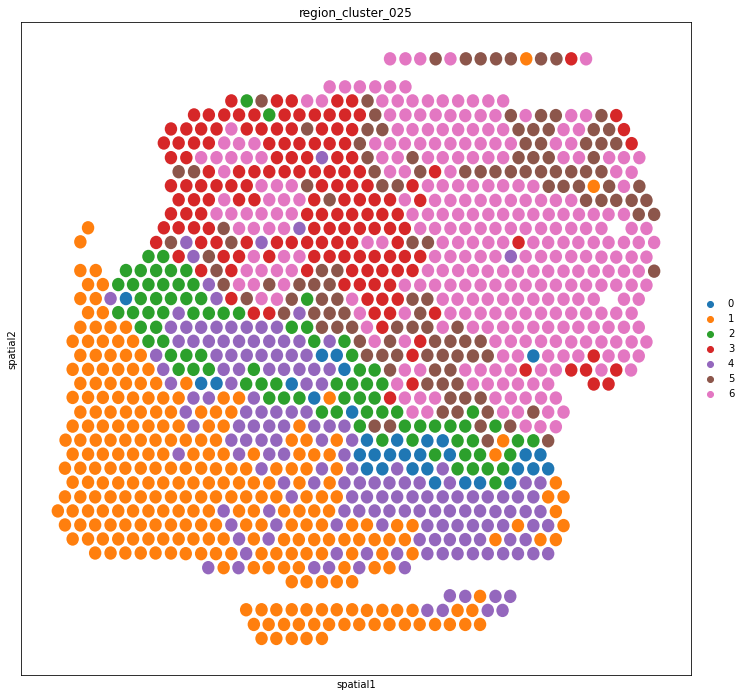

In [9]:
with mpl.rc_context({'figure.figsize': (12, 12)}):
  sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="Count_SN123_A595688_Rep1"],
                  color=["region_cluster_025"], size= 0.15, img_key=None
                )

### Higher Resolution = 0.75 (More clusters)


In [10]:
sample_type = 'q05_nUMI_factors'
col_ind = [sample_type in i for i in adata_vis.obs.columns.tolist()]
adata_vis.obsm[sample_type] = adata_vis.obs.loc[:,col_ind].values

# compute KNN using the cell2location output
sc.pp.neighbors(adata_vis, use_rep=sample_type,
                n_neighbors = 30)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=0.75)

# add region as categorical variable
adata_vis.obs["region_cluster_075"] = adata_vis.obs["leiden"]
adata_vis.obs["region_cluster_075"] =  adata_vis.obs["region_cluster_075"].astype("category")

In [11]:
sc.tl.umap(adata_vis, min_dist = 0.75, spread = 1)

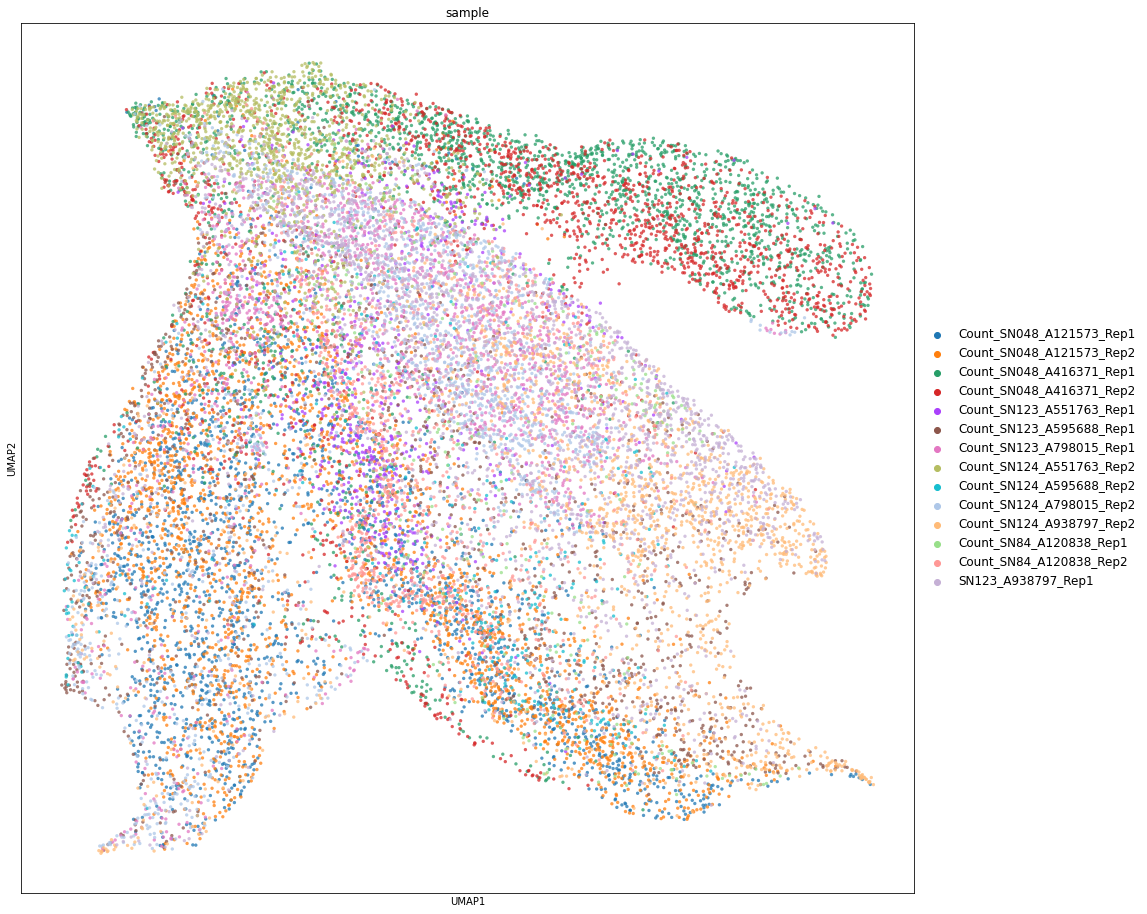

In [12]:
with mpl.rc_context({'figure.figsize': (16, 16)}):
    sc.pl.umap(adata_vis, color=['sample'], size=45,
               color_map = 'RdPu',
               legend_fontsize=12, alpha=0.75)

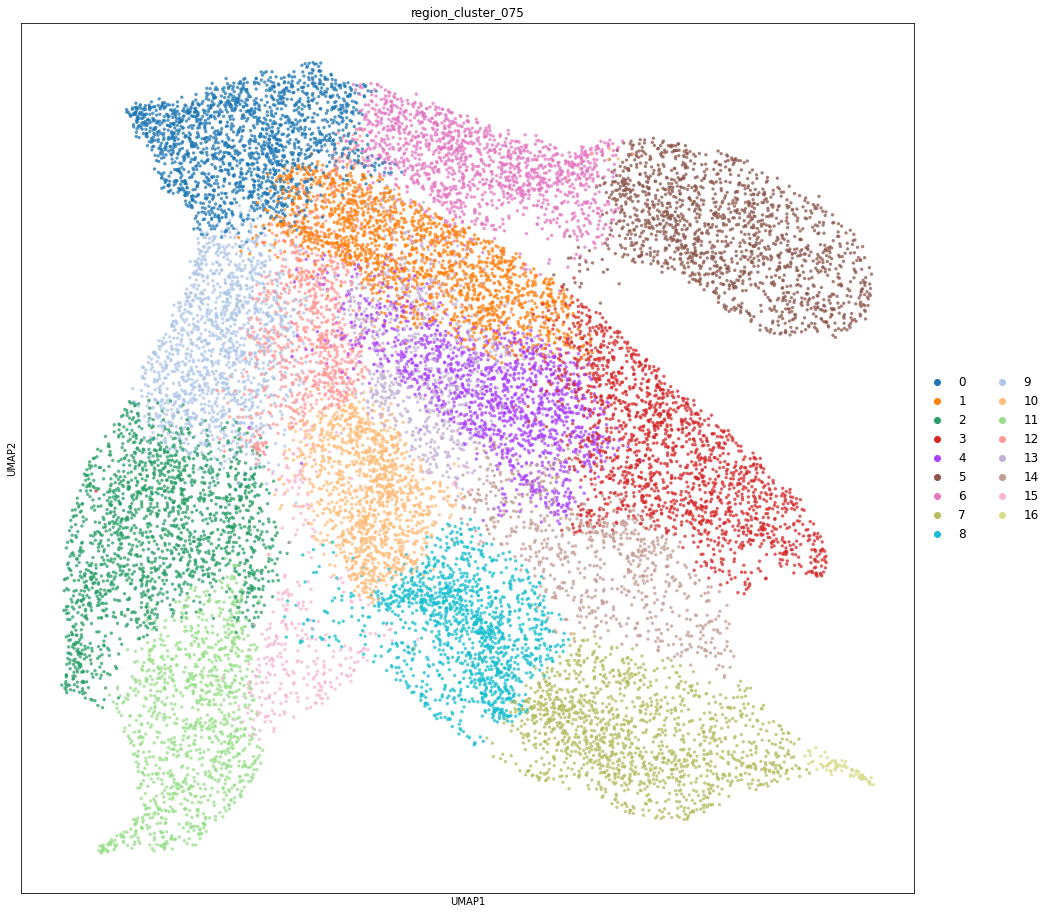

In [13]:
with mpl.rc_context({'figure.figsize': (16, 16)}):
    sc.pl.umap(adata_vis, color=['region_cluster_075'], size=45,
               color_map = 'RdPu',
               legend_fontsize=12, alpha=0.75)

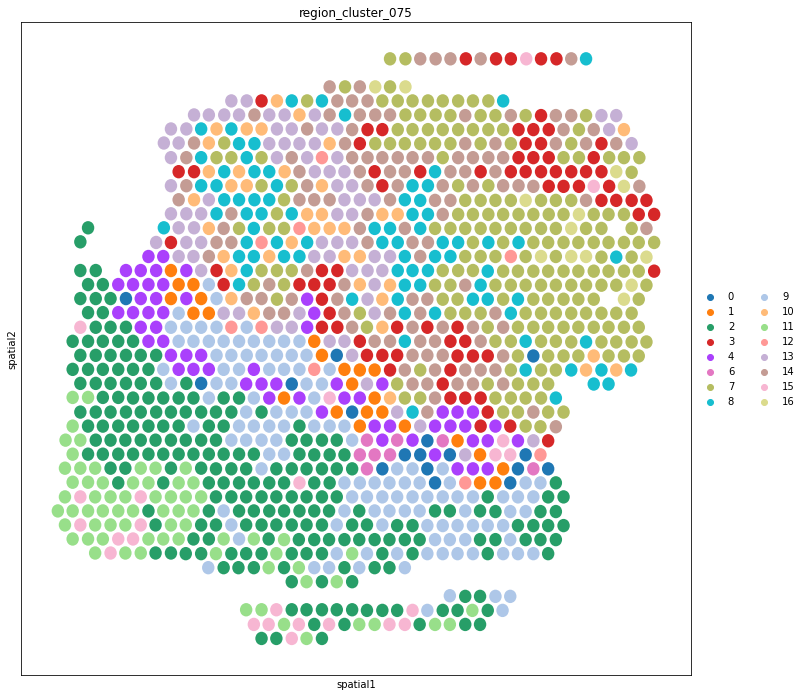

In [14]:
with mpl.rc_context({'figure.figsize': (12, 12)}):
  sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="Count_SN123_A595688_Rep1"],
                  color=["region_cluster_075"], size= 0.15, img_key=None
                )

We save the results to compute the Neigborhod enrichment analysis in the following script.

In [15]:
sp_data_New_file = results_folder +r['run_name']+'/sp_clusters_proportions.h5ad'
adata_vis.write(filename=sp_data_New_file)

## 2.- Cell types abundances per sample

In [16]:
samples = {'sample_name': ['Count_SN048_A121573_Rep1', 'Count_SN048_A121573_Rep2', 'Count_SN048_A416371_Rep1', 
    'Count_SN048_A416371_Rep2','Count_SN123_A551763_Rep1', 'Count_SN123_A595688_Rep1', 'Count_SN123_A798015_Rep1', 
    'Count_SN124_A551763_Rep2','Count_SN124_A595688_Rep2','Count_SN124_A798015_Rep2',
    'Count_SN124_A938797_Rep2','Count_SN84_A120838_Rep1','Count_SN84_A120838_Rep2', 'SN123_A938797_Rep1']}
sample_data = pd.DataFrame(data=samples)
sample_type = 'q05_nUMI_factors'
col_ind = [sample_type in i for i in adata_vis.obs.columns.tolist()]
df=pd.DataFrame()

In [17]:
for i in sample_data['sample_name']:
    adata_sample = adata_vis.obs.query('sample == @i')
    adata_sample_celltypes = adata_sample.loc[:,col_ind]
    per_sample_percelltype_counts = adata_sample_celltypes.sum()
    df[i] = per_sample_percelltype_counts

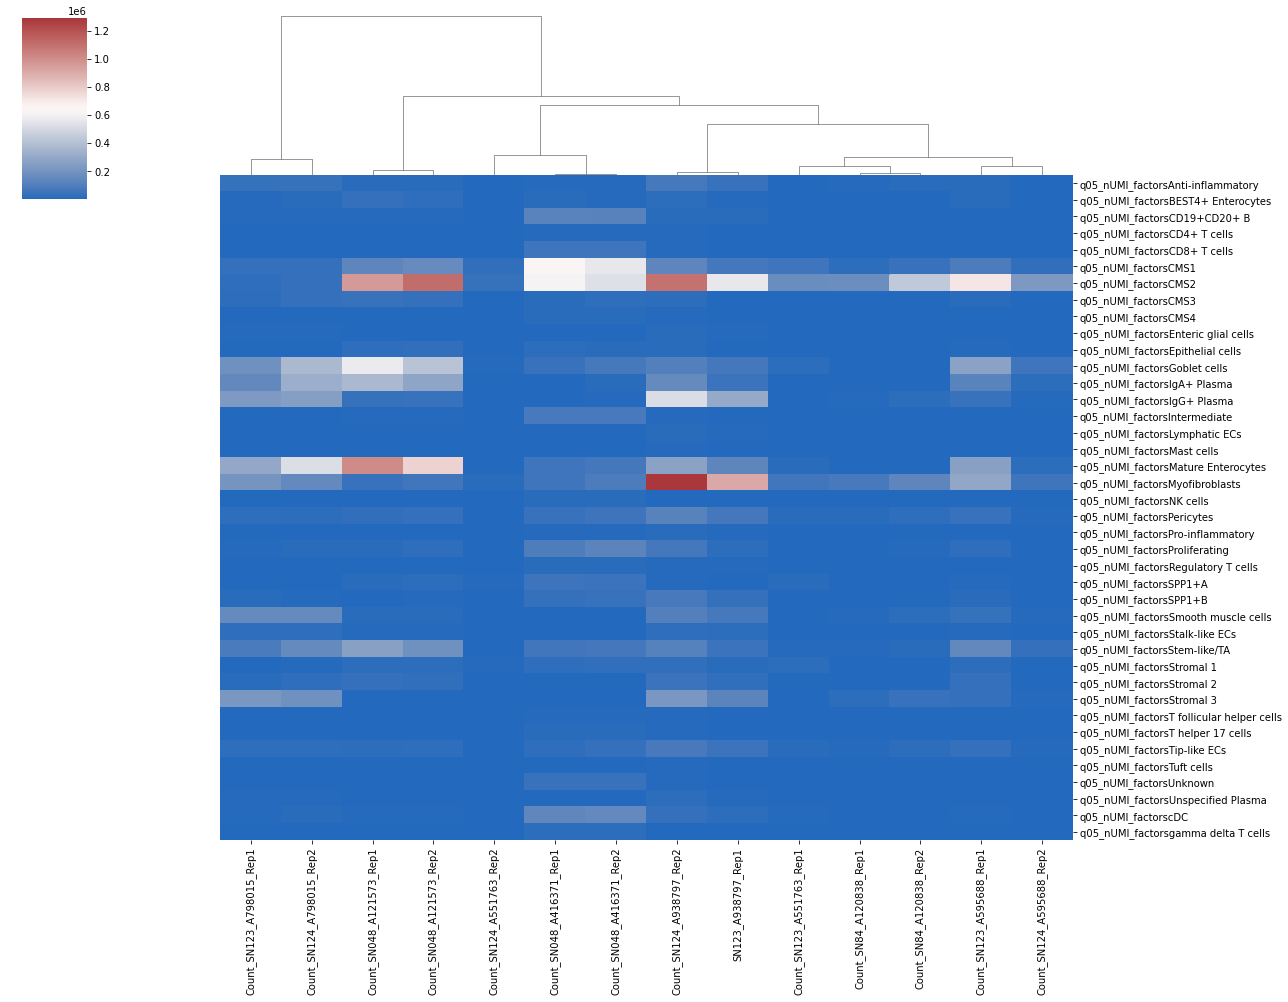

In [18]:
g = sns.clustermap(df,figsize=(18, 14),row_cluster=False,cmap="vlag", metric='correlation')

### 3-. Identify groups of co-located cell types using matrix factorisation

From Cell2Location tutorial: Tip If you want to find a few most disctinct cellular compartments, use a small number of factors. If you want to find very strong co-location signal and assume that most cell types don’t co-locate, use a lot of factors (> 30 - used here). In practice, it is better to train NMF for a range of factors R=5,..,30 and select R as a balance between capturing fine tissue zones and splitting known compartments

In [19]:
samples_to_consider = ['Count_SN048_A121573_Rep1', 'Count_SN048_A121573_Rep2', 'Count_SN048_A416371_Rep1', 
    'Count_SN048_A416371_Rep2','Count_SN123_A551763_Rep1', 'Count_SN123_A595688_Rep1', 'Count_SN123_A798015_Rep1', 
    'Count_SN124_A551763_Rep2','Count_SN124_A595688_Rep2','Count_SN124_A798015_Rep2',
    'Count_SN124_A938797_Rep2','Count_SN84_A120838_Rep1','Count_SN84_A120838_Rep2', 'SN123_A938797_Rep1']
adata_vis = adata_vis[adata_vis.obs['sample'].isin(samples_to_consider),:]

### R = 3

In [20]:
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']
len(X_data)

20654

In [21]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(3)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 9811
init_2 - iterations until convergence: 9896
init_3 - iterations until convergence: 9274
init_4 - iterations until convergence: 9656
init_5 - iterations until convergence: 10000


In [22]:
len(X_data)

20654

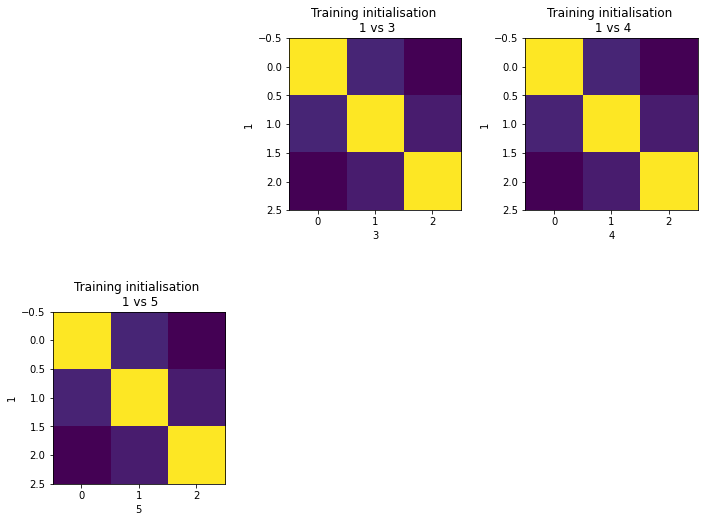

In [23]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

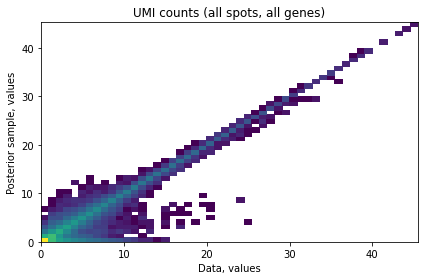

In [24]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [25]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

Trying to set attribute `.obs` of view, copying.


top-1                 top-2  \
mean_cell_type_factorsfact_0               CMS2: 0.98  Myofibroblasts: 0.79   
mean_cell_type_factorsfact_1  Mature Enterocytes: 1.0     Goblet cells: 1.0   
mean_cell_type_factorsfact_2        CD8+ T cells: 1.0     CD19+CD20+ B: 1.0   

                                          top-3                   top-4  \
mean_cell_type_factorsfact_0  IgG+ Plasma: 0.68  Epithelial cells: 0.58   
mean_cell_type_factorsfact_1  IgA+ Plasma: 0.89              CMS3: 0.85   
mean_cell_type_factorsfact_2      Unknown: 0.99               cDC: 0.98   

                                           top-5             top-6  \
mean_cell_type_factorsfact_0     Stromal 3: 0.57  Tuft cells: 0.49   
mean_cell_type_factorsfact_1  Stem-like/TA: 0.81   Stromal 2: 0.72   
mean_cell_type_factorsfact_2  Intermediate: 0.97    NK cells: 0.94   

                                                  top-7  \
mean_cell_type_factorsfact_0            Pericytes: 0.45   
mean_cell_type_factorsfact_1   BEST4+ Enterocytes: 0.69   
mean_cell_type_factorsfact_2  gamma delta T cells: 0.91   

                                                  top-8               top-9  
mean_cell_type_factorsfact_0  Smooth muscle cells: 0.41  Lymphatic ECs: 0.4  
mean_cell_type_factorsfact_1       Stalk-like ECs: 0.59    Mast cells: 0.43  
mean_cell_type_factorsfact_2        Proliferating: 0.86        SPP1+B: 0.85

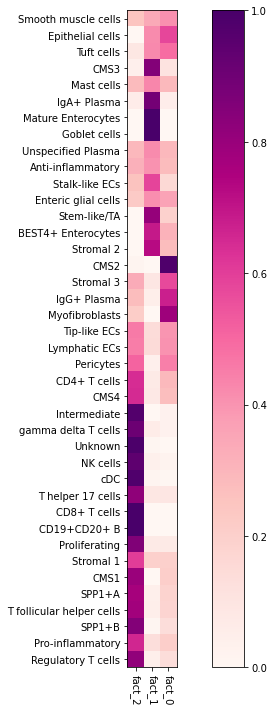

In [26]:
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

In [27]:
mod_sk.cell_type_fractions.to_csv(path_or_buf="Cell2Location/results/colocalizationFactors/R3.csv")

### R = 4

In [28]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(4)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 9276
init_2 - iterations until convergence: 10000
init_3 - iterations until convergence: 9003
init_4 - iterations until convergence: 9664
init_5 - iterations until convergence: 9049


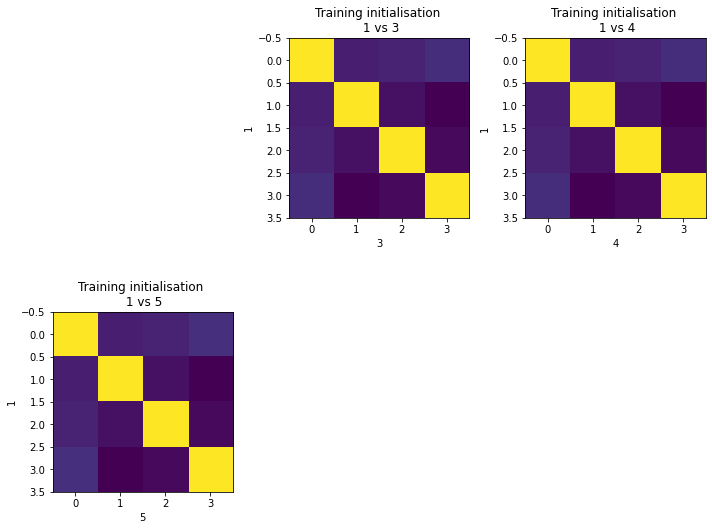

In [29]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

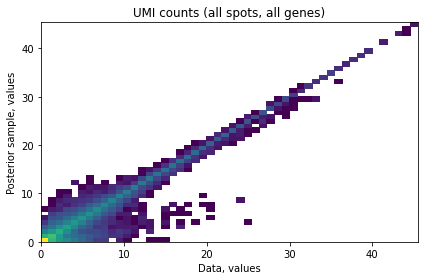

In [30]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [31]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1                   top-2  \
mean_cell_type_factorsfact_0       CD19+CD20+ B: 0.98      CD8+ T cells: 0.95   
mean_cell_type_factorsfact_1               CMS2: 0.97  Epithelial cells: 0.58   
mean_cell_type_factorsfact_2           Stromal 3: 1.0        IgG+ Plasma: 1.0   
mean_cell_type_factorsfact_3  Mature Enterocytes: 1.0      Goblet cells: 0.98   

                                             top-3                      top-4  \
mean_cell_type_factorsfact_0    Intermediate: 0.95              Unknown: 0.91   
mean_cell_type_factorsfact_1      Tuft cells: 0.33   BEST4+ Enterocytes: 0.31   
mean_cell_type_factorsfact_2  Myofibroblasts: 0.99  Smooth muscle cells: 0.96   
mean_cell_type_factorsfact_3            CMS3: 0.85         Stem-like/TA: 0.81   

                                                 top-5  \
mean_cell_type_factorsfact_0                 cDC: 0.85   
mean_cell_type_factorsfact_1                CMS1: 0.21   
mean_cell_type_factorsfact_2          Mast cells: 0.87   
mean_cell_type_factorsfact_3  BEST4+ Enterocytes: 0.69   

                                                top-6  \
mean_cell_type_factorsfact_0               CMS1: 0.79   
mean_cell_type_factorsfact_1                CMS4: 0.2   
mean_cell_type_factorsfact_2  Anti-inflammatory: 0.85   
mean_cell_type_factorsfact_3        IgA+ Plasma: 0.67   

                                                  top-7  \
mean_cell_type_factorsfact_0             NK cells: 0.79   
mean_cell_type_factorsfact_1         Stem-like/TA: 0.19   
mean_cell_type_factorsfact_2  Enteric glial cells: 0.85   
mean_cell_type_factorsfact_3            Stromal 2: 0.47   

                                                  top-8  \
mean_cell_type_factorsfact_0  gamma delta T cells: 0.73   
mean_cell_type_factorsfact_1               SPP1+A: 0.17   
mean_cell_type_factorsfact_2        Lymphatic ECs: 0.85   
mean_cell_type_factorsfact_3     Epithelial cells: 0.42   

                                                 top-9  
mean_cell_type_factorsfact_0              SPP1+A: 0.71  
mean_cell_type_factorsfact_1        CD4+ T cells: 0.16  
mean_cell_type_factorsfact_2  Unspecified Plasma: 0.84  
mean_cell_type_factorsfact_3          Tuft cells: 0.32

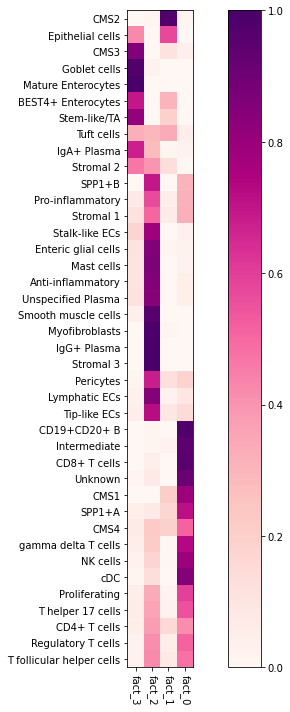

In [32]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

### R = 5

In [33]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(5)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 9017
init_2 - iterations until convergence: 8665
init_3 - iterations until convergence: 7945
init_4 - iterations until convergence: 8551
init_5 - iterations until convergence: 8814


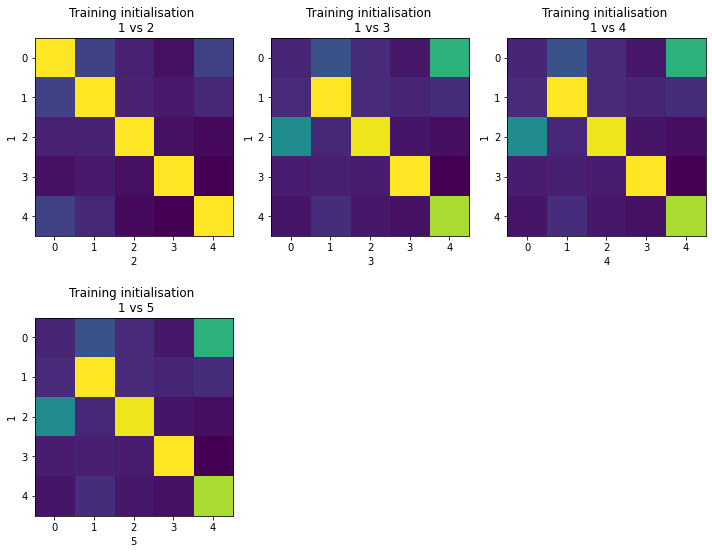

In [34]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

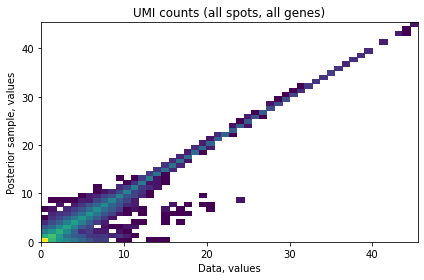

In [35]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [36]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0                CMS2: 0.97   
mean_cell_type_factorsfact_1        CD19+CD20+ B: 0.97   
mean_cell_type_factorsfact_2         IgG+ Plasma: 0.99   
mean_cell_type_factorsfact_3  Mature Enterocytes: 0.96   
mean_cell_type_factorsfact_4        Stem-like/TA: 0.95   

                                               top-2  \
mean_cell_type_factorsfact_0  Epithelial cells: 0.47   
mean_cell_type_factorsfact_1      CD8+ T cells: 0.95   
mean_cell_type_factorsfact_2    Myofibroblasts: 0.99   
mean_cell_type_factorsfact_3       IgA+ Plasma: 0.46   
mean_cell_type_factorsfact_4      Goblet cells: 0.85   

                                                 top-3  \
mean_cell_type_factorsfact_0          Tuft cells: 0.27   
mean_cell_type_factorsfact_1        Intermediate: 0.95   
mean_cell_type_factorsfact_2           Stromal 3: 0.98   
mean_cell_type_factorsfact_3                CMS3: 0.44   
mean_cell_type_factorsfact_4  BEST4+ Enterocytes: 0.58   

                                                  top-4  \
mean_cell_type_factorsfact_0                  CMS1: 0.2   
mean_cell_type_factorsfact_1               Unknown: 0.9   
mean_cell_type_factorsfact_2  Smooth muscle cells: 0.87   
mean_cell_type_factorsfact_3            Stromal 2: 0.36   
mean_cell_type_factorsfact_4                 CMS3: 0.45   

                                                top-5  \
mean_cell_type_factorsfact_0               CMS4: 0.19   
mean_cell_type_factorsfact_1                cDC: 0.84   
mean_cell_type_factorsfact_2  Anti-inflammatory: 0.84   
mean_cell_type_factorsfact_3   Epithelial cells: 0.25   
mean_cell_type_factorsfact_4        IgA+ Plasma: 0.28   

                                                 top-6             top-7  \
mean_cell_type_factorsfact_0  BEST4+ Enterocytes: 0.19      SPP1+A: 0.17   
mean_cell_type_factorsfact_1                CMS1: 0.79    NK cells: 0.78   
mean_cell_type_factorsfact_2  Unspecified Plasma: 0.82  Mast cells: 0.81   
mean_cell_type_factorsfact_3  BEST4+ Enterocytes: 0.23  Tuft cells: 0.17   
mean_cell_type_factorsfact_4    Epithelial cells: 0.28  Tuft cells: 0.27   

                                                  top-8  \
mean_cell_type_factorsfact_0         CD4+ T cells: 0.15   
mean_cell_type_factorsfact_1  gamma delta T cells: 0.72   
mean_cell_type_factorsfact_2         Lymphatic ECs: 0.8   
mean_cell_type_factorsfact_3         Goblet cells: 0.15   
mean_cell_type_factorsfact_4       Stalk-like ECs: 0.21   

                                                  top-9  
mean_cell_type_factorsfact_0            Pericytes: 0.12  
mean_cell_type_factorsfact_1               SPP1+A: 0.71  
mean_cell_type_factorsfact_2  Enteric glial cells: 0.79  
mean_cell_type_factorsfact_3  Unspecified Plasma: 0.099  
mean_cell_type_factorsfact_4            Stromal 2: 0.18

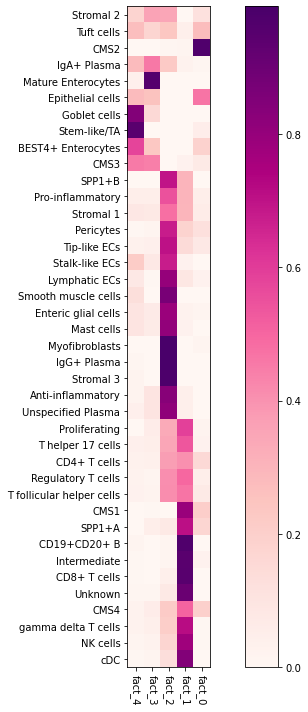

In [37]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

Trying to set attribute `.uns` of view, copying.


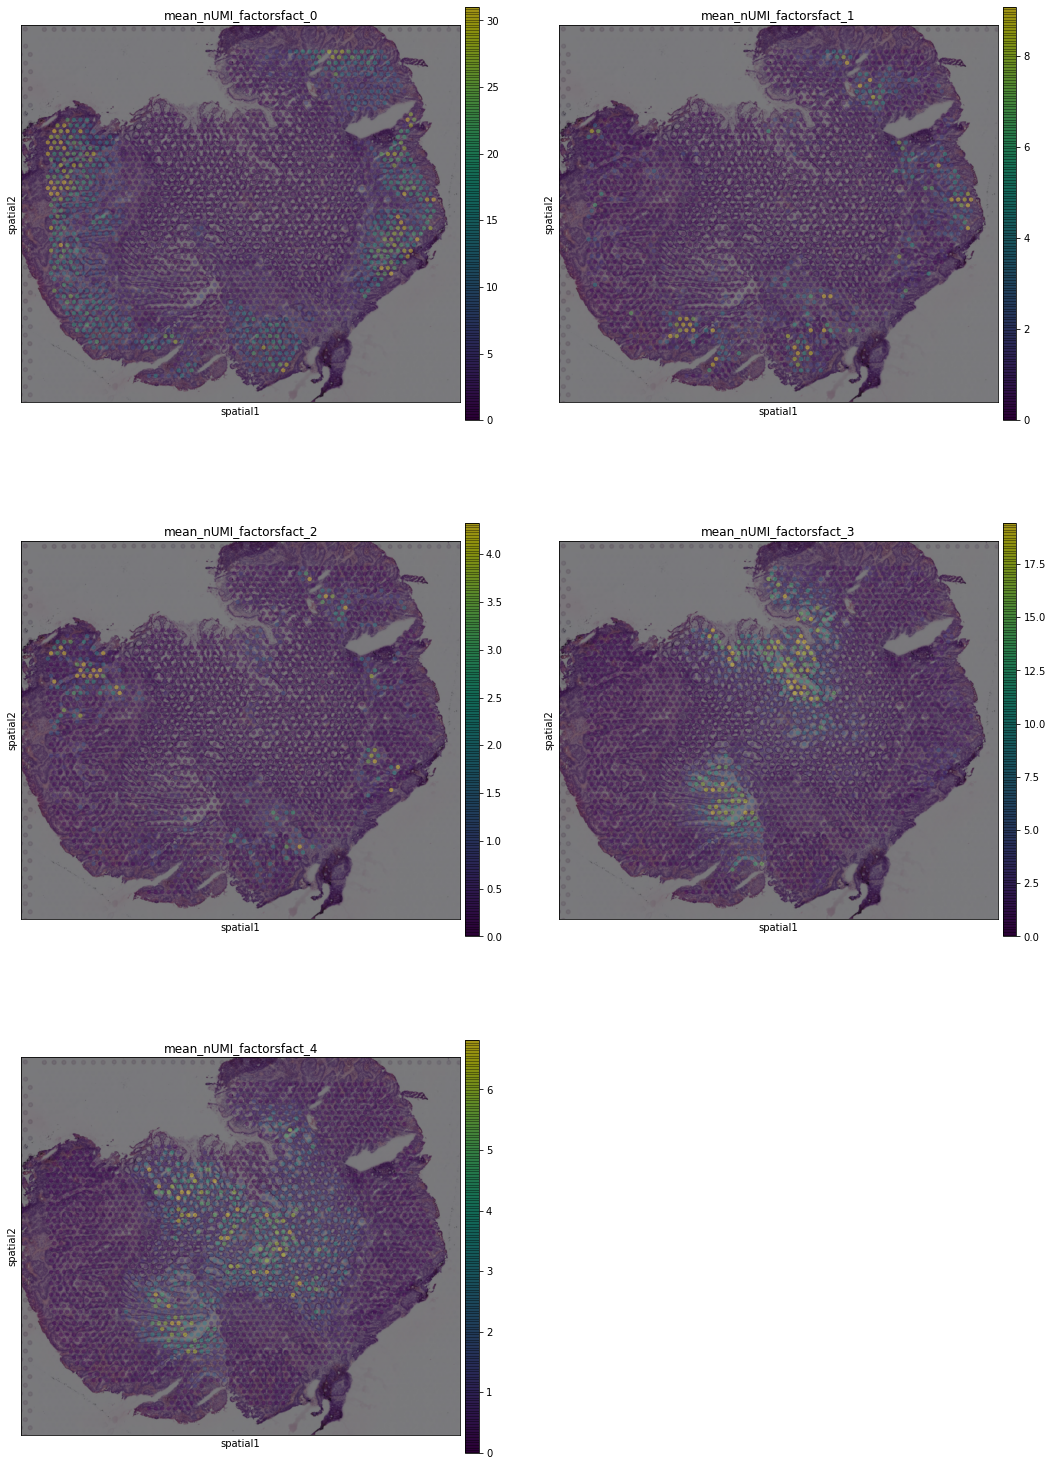

In [38]:
# plot cell density in each combination
with mpl.rc_context({'figure.figsize': (8, 8), 'axes.facecolor': 'black'}):

    # select one section correctly subsetting histology image data
    slide = select_slide(adata_vis, 'Count_SN048_A121573_Rep2')

    sc.pl.spatial(slide,
                  cmap='viridis',
                  color=mod_sk.location_factors_df.columns,
                  size=1, img_key='hires',
                  alpha_img=0.5, alpha = 0.4, ncols=2,
                  vmin=0, vmax='p99.2'
                 )

Trying to set attribute `.uns` of view, copying.


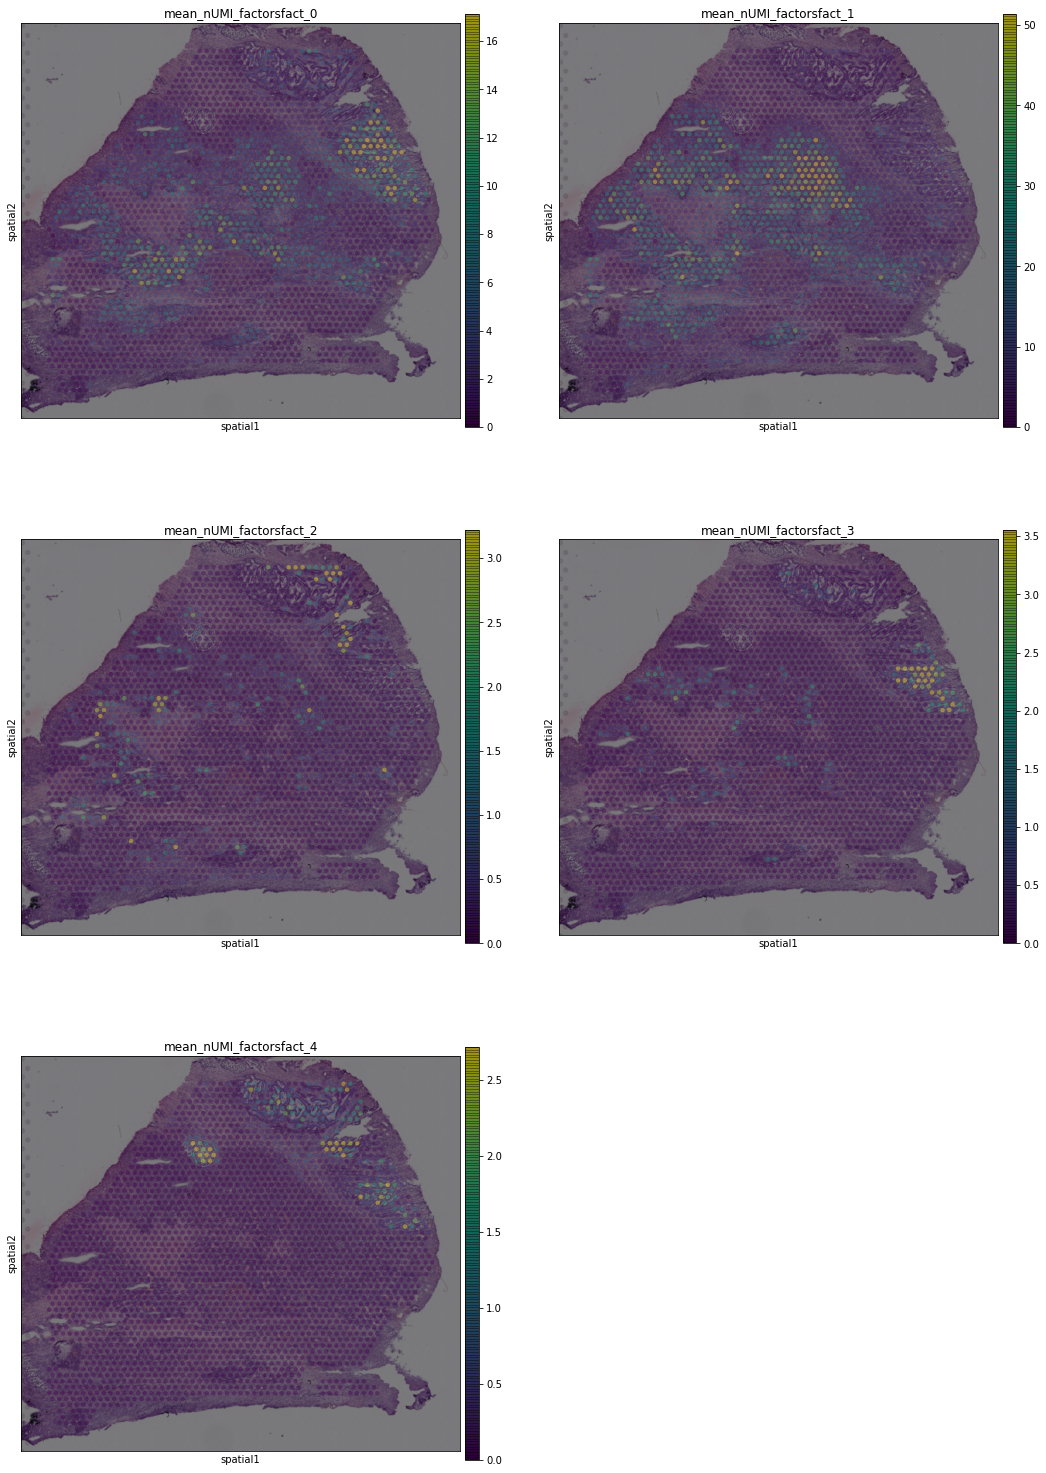

In [39]:
# plot cell density in each combination
with mpl.rc_context({'figure.figsize': (8, 8), 'axes.facecolor': 'black'}):

    # select one section correctly subsetting histology image data
    slide = select_slide(adata_vis, 'Count_SN048_A416371_Rep1')

    sc.pl.spatial(slide,
                  cmap='viridis',
                  color=mod_sk.location_factors_df.columns,
                  size=1, img_key='hires',
                  alpha_img=0.5, alpha = 0.4, ncols=2,
                  vmin=0, vmax='p99.2'
                 )

### R = 6

In [40]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(6)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 8655
init_2 - iterations until convergence: 7295
init_3 - iterations until convergence: 8363
init_4 - iterations until convergence: 8422
init_5 - iterations until convergence: 9025


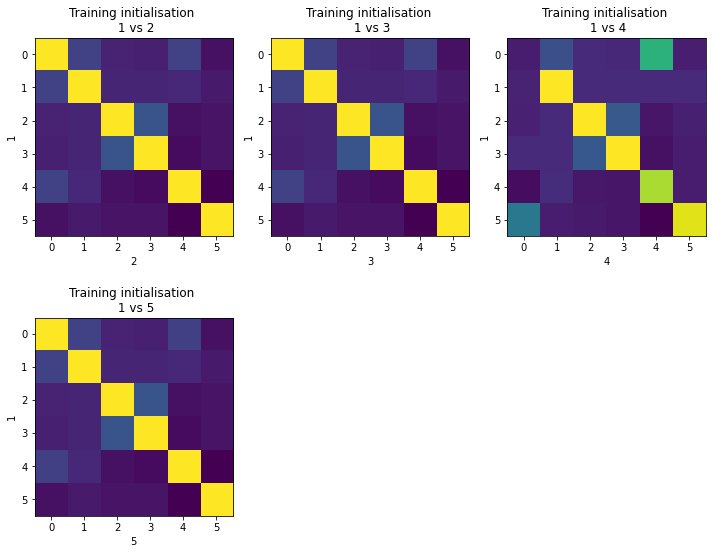

In [41]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

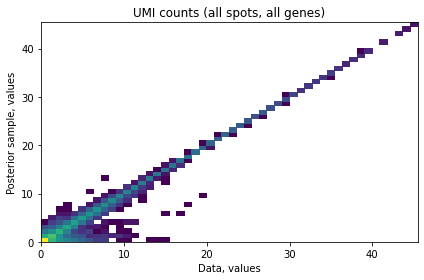

In [42]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [43]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0                CMS2: 0.94   
mean_cell_type_factorsfact_1  Mature Enterocytes: 0.96   
mean_cell_type_factorsfact_2                CMS1: 0.85   
mean_cell_type_factorsfact_3      Myofibroblasts: 0.99   
mean_cell_type_factorsfact_4        Stem-like/TA: 0.95   
mean_cell_type_factorsfact_5        CD8+ T cells: 0.95   

                                               top-2  \
mean_cell_type_factorsfact_0  Epithelial cells: 0.43   
mean_cell_type_factorsfact_1       IgA+ Plasma: 0.46   
mean_cell_type_factorsfact_2            SPP1+A: 0.63   
mean_cell_type_factorsfact_3       IgG+ Plasma: 0.99   
mean_cell_type_factorsfact_4      Goblet cells: 0.85   
mean_cell_type_factorsfact_5      CD19+CD20+ B: 0.92   

                                                 top-3  \
mean_cell_type_factorsfact_0          Tuft cells: 0.27   
mean_cell_type_factorsfact_1                CMS3: 0.42   
mean_cell_type_factorsfact_2                 cDC: 0.25   
mean_cell_type_factorsfact_3           Stromal 3: 0.98   
mean_cell_type_factorsfact_4  BEST4+ Enterocytes: 0.58   
mean_cell_type_factorsfact_5             Unknown: 0.82   

                                                  top-4  \
mean_cell_type_factorsfact_0   BEST4+ Enterocytes: 0.19   
mean_cell_type_factorsfact_1            Stromal 2: 0.36   
mean_cell_type_factorsfact_2                 CMS4: 0.24   
mean_cell_type_factorsfact_3  Smooth muscle cells: 0.87   
mean_cell_type_factorsfact_4                 CMS3: 0.43   
mean_cell_type_factorsfact_5         Intermediate: 0.81   

                                                top-5  \
mean_cell_type_factorsfact_0               CMS4: 0.16   
mean_cell_type_factorsfact_1   Epithelial cells: 0.24   
mean_cell_type_factorsfact_2       Intermediate: 0.17   
mean_cell_type_factorsfact_3  Anti-inflammatory: 0.82   
mean_cell_type_factorsfact_4        IgA+ Plasma: 0.28   
mean_cell_type_factorsfact_5           NK cells: 0.76   

                                                  top-6  \
mean_cell_type_factorsfact_0         CD4+ T cells: 0.14   
mean_cell_type_factorsfact_1   BEST4+ Enterocytes: 0.23   
mean_cell_type_factorsfact_2              Unknown: 0.12   
mean_cell_type_factorsfact_3    Unspecified Plasma: 0.8   
mean_cell_type_factorsfact_4           Tuft cells: 0.26   
mean_cell_type_factorsfact_5  gamma delta T cells: 0.75   

                                               top-7                 top-8  \
mean_cell_type_factorsfact_0         Pericytes: 0.12       Stromal 2: 0.12   
mean_cell_type_factorsfact_1        Tuft cells: 0.17    Goblet cells: 0.15   
mean_cell_type_factorsfact_2        Stromal 1: 0.093           CMS3: 0.092   
mean_cell_type_factorsfact_3         Mast cells: 0.8   Lymphatic ECs: 0.78   
mean_cell_type_factorsfact_4  Epithelial cells: 0.26  Stalk-like ECs: 0.21   
mean_cell_type_factorsfact_5     Proliferating: 0.64             cDC: 0.64   

                                                  top-9  
mean_cell_type_factorsfact_0                 CMS1: 0.08  
mean_cell_type_factorsfact_1  Unspecified Plasma: 0.098  
mean_cell_type_factorsfact_2        CD19+CD20+ B: 0.069  
mean_cell_type_factorsfact_3  Enteric glial cells: 0.76  
mean_cell_type_factorsfact_4            Stromal 2: 0.18  
mean_cell_type_factorsfact_5    T helper 17 cells: 0.55

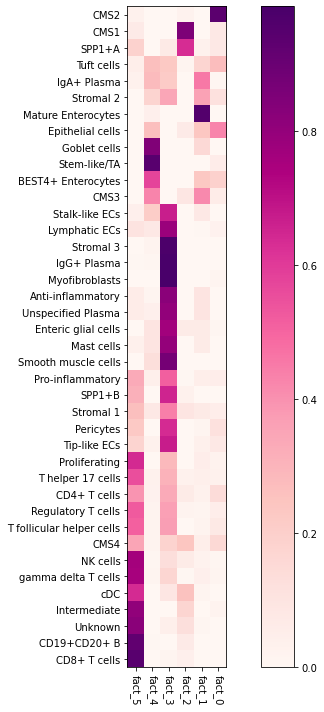

In [44]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

### R = 7

In [45]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(7)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 8126
init_2 - iterations until convergence: 7114
init_3 - iterations until convergence: 7257
init_4 - iterations until convergence: 7302
init_5 - iterations until convergence: 7339


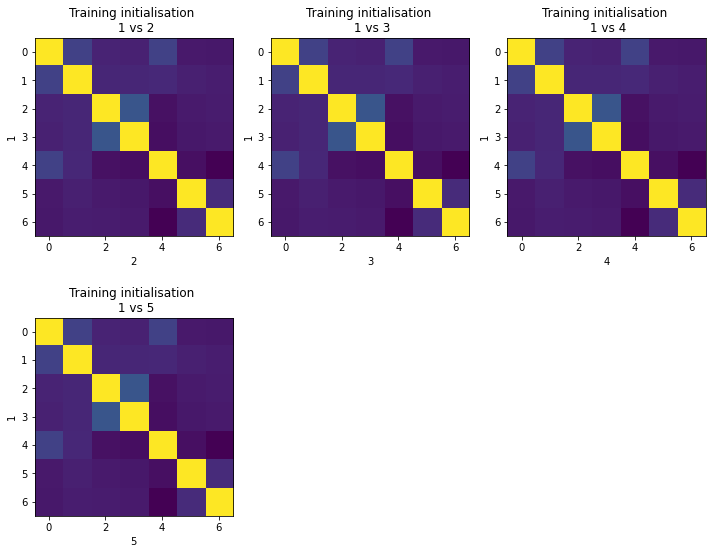

In [46]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

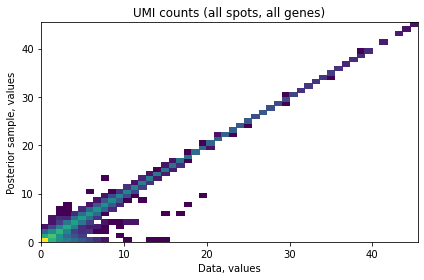

In [47]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [48]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0                 CMS1: 0.85   
mean_cell_type_factorsfact_1        Myofibroblasts: 1.0   
mean_cell_type_factorsfact_2   Mature Enterocytes: 0.96   
mean_cell_type_factorsfact_3                 CMS2: 0.94   
mean_cell_type_factorsfact_4         CD8+ T cells: 0.94   
mean_cell_type_factorsfact_5  Smooth muscle cells: 0.99   
mean_cell_type_factorsfact_6         Stem-like/TA: 0.95   

                                               top-2  \
mean_cell_type_factorsfact_0            SPP1+A: 0.63   
mean_cell_type_factorsfact_1            SPP1+B: 0.67   
mean_cell_type_factorsfact_2              CMS3: 0.41   
mean_cell_type_factorsfact_3  Epithelial cells: 0.43   
mean_cell_type_factorsfact_4      CD19+CD20+ B: 0.92   
mean_cell_type_factorsfact_5    Stalk-like ECs: 0.75   
mean_cell_type_factorsfact_6      Goblet cells: 0.85   

                                                 top-3  \
mean_cell_type_factorsfact_0                 cDC: 0.25   
mean_cell_type_factorsfact_1  Unspecified Plasma: 0.52   
mean_cell_type_factorsfact_2         IgA+ Plasma: 0.38   
mean_cell_type_factorsfact_3          Tuft cells: 0.25   
mean_cell_type_factorsfact_4             Unknown: 0.82   
mean_cell_type_factorsfact_5            Stromal 3: 0.7   
mean_cell_type_factorsfact_6  BEST4+ Enterocytes: 0.58   

                                                 top-4  \
mean_cell_type_factorsfact_0                CMS4: 0.23   
mean_cell_type_factorsfact_1         IgG+ Plasma: 0.51   
mean_cell_type_factorsfact_2           Stromal 2: 0.32   
mean_cell_type_factorsfact_3  BEST4+ Enterocytes: 0.19   
mean_cell_type_factorsfact_4        Intermediate: 0.81   
mean_cell_type_factorsfact_5       Lymphatic ECs: 0.56   
mean_cell_type_factorsfact_6                CMS3: 0.42   

                                                  top-5  \
mean_cell_type_factorsfact_0         Intermediate: 0.17   
mean_cell_type_factorsfact_1    Anti-inflammatory: 0.46   
mean_cell_type_factorsfact_2     Epithelial cells: 0.24   
mean_cell_type_factorsfact_3                 CMS4: 0.15   
mean_cell_type_factorsfact_4             NK cells: 0.74   
mean_cell_type_factorsfact_5  Enteric glial cells: 0.52   
mean_cell_type_factorsfact_6     Epithelial cells: 0.27   

                                                  top-6  \
mean_cell_type_factorsfact_0              Unknown: 0.12   
mean_cell_type_factorsfact_1            Pericytes: 0.45   
mean_cell_type_factorsfact_2   BEST4+ Enterocytes: 0.23   
mean_cell_type_factorsfact_3         CD4+ T cells: 0.13   
mean_cell_type_factorsfact_4  gamma delta T cells: 0.73   
mean_cell_type_factorsfact_5          IgG+ Plasma: 0.49   
mean_cell_type_factorsfact_6           Tuft cells: 0.24   

                                               top-7                    top-8  \
mean_cell_type_factorsfact_0             CMS3: 0.092         Stromal 1: 0.085   
mean_cell_type_factorsfact_1  Pro-inflammatory: 0.41          Mast cells: 0.4   
mean_cell_type_factorsfact_2        Tuft cells: 0.16       Goblet cells: 0.15   
mean_cell_type_factorsfact_3          Stromal 2: 0.1         Pericytes: 0.095   
mean_cell_type_factorsfact_4     Proliferating: 0.63                cDC: 0.62   
mean_cell_type_factorsfact_5        Mast cells: 0.47  Anti-inflammatory: 0.42   
mean_cell_type_factorsfact_6       IgA+ Plasma: 0.22          Stromal 2: 0.15   

                                                  top-9  
mean_cell_type_factorsfact_0    Epithelial cells: 0.068  
mean_cell_type_factorsfact_1         Tip-like ECs: 0.39  
mean_cell_type_factorsfact_2  Unspecified Plasma: 0.077  
mean_cell_type_factorsfact_3                CMS1: 0.078  
mean_cell_type_factorsfact_4    T helper 17 cells: 0.51  
mean_cell_type_factorsfact_5         Tip-like ECs: 0.37  
mean_cell_type_factorsfact_6      Stalk-like ECs: 0.083

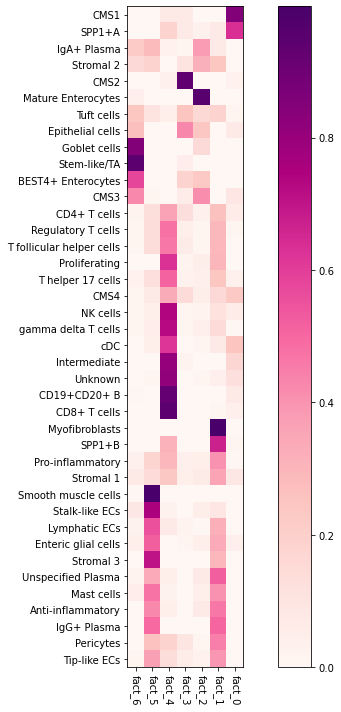

In [49]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

In [50]:
mod_sk.cell_type_fractions.to_csv(path_or_buf="Cell2Location/results/colocalizationFactors/R7.csv")

Trying to set attribute `.uns` of view, copying.


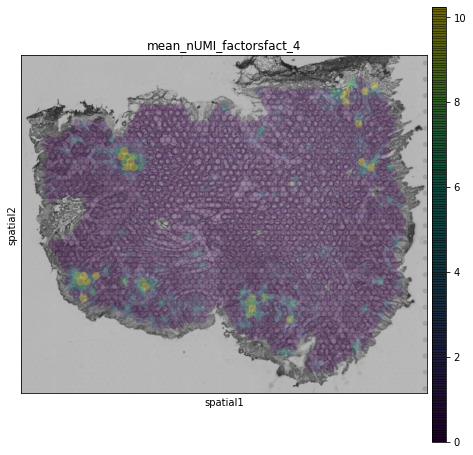

In [51]:
# plot cell density in each combination
with mpl.rc_context({'figure.figsize': (8, 8), 'axes.facecolor': 'black'}):

    # select one section correctly subsetting histology image data
    slide = select_slide(adata_vis, 'Count_SN048_A121573_Rep1')

    sc.pl.spatial(slide,
                  cmap='viridis',
                  color='mean_nUMI_factorsfact_4',
                  size=2, img_key='hires',
                  alpha_img=0.75, alpha = 0.25,
                  vmin=0, vmax='p99.2', bw = True 
                 )

### R = 8

In [52]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(8)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 7993
init_2 - iterations until convergence: 7625
init_3 - iterations until convergence: 7803
init_4 - iterations until convergence: 6603
init_5 - iterations until convergence: 7981


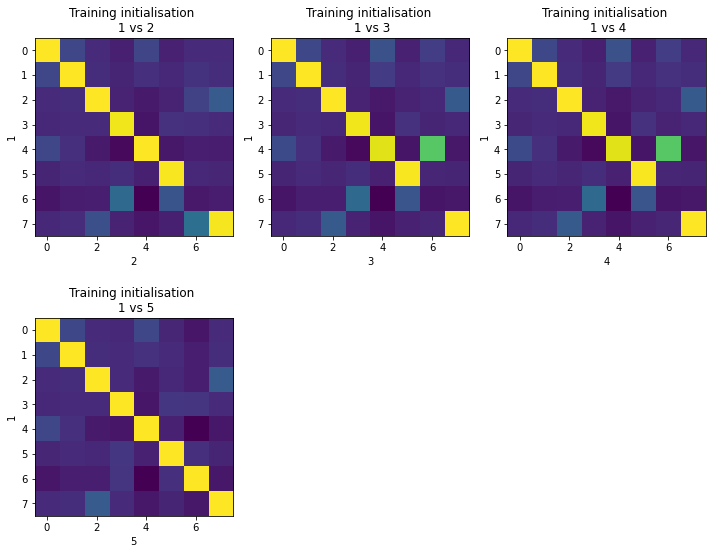

In [53]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

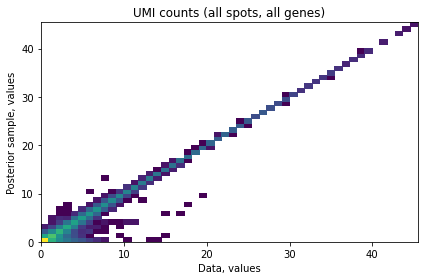

In [54]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [55]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0                 CMS1: 0.85   
mean_cell_type_factorsfact_1          IgG+ Plasma: 0.96   
mean_cell_type_factorsfact_2  Smooth muscle cells: 0.97   
mean_cell_type_factorsfact_3   Mature Enterocytes: 0.96   
mean_cell_type_factorsfact_4         CD8+ T cells: 0.95   
mean_cell_type_factorsfact_5       Myofibroblasts: 0.98   
mean_cell_type_factorsfact_6         Stem-like/TA: 0.95   
mean_cell_type_factorsfact_7                 CMS2: 0.94   

                                               top-2  \
mean_cell_type_factorsfact_0            SPP1+A: 0.59   
mean_cell_type_factorsfact_1         Pericytes: 0.67   
mean_cell_type_factorsfact_2         Stromal 3: 0.42   
mean_cell_type_factorsfact_3              CMS3: 0.41   
mean_cell_type_factorsfact_4      CD19+CD20+ B: 0.93   
mean_cell_type_factorsfact_5            SPP1+B: 0.67   
mean_cell_type_factorsfact_6      Goblet cells: 0.85   
mean_cell_type_factorsfact_7  Epithelial cells: 0.43   

                                                 top-3  \
mean_cell_type_factorsfact_0                 cDC: 0.24   
mean_cell_type_factorsfact_1        Tip-like ECs: 0.65   
mean_cell_type_factorsfact_2      Stalk-like ECs: 0.39   
mean_cell_type_factorsfact_3    Epithelial cells: 0.24   
mean_cell_type_factorsfact_4        Intermediate: 0.81   
mean_cell_type_factorsfact_5   Unspecified Plasma: 0.3   
mean_cell_type_factorsfact_6  BEST4+ Enterocytes: 0.58   
mean_cell_type_factorsfact_7          Tuft cells: 0.22   

                                                 top-4  \
mean_cell_type_factorsfact_0                CMS4: 0.22   
mean_cell_type_factorsfact_1         IgA+ Plasma: 0.64   
mean_cell_type_factorsfact_2       Lymphatic ECs: 0.32   
mean_cell_type_factorsfact_3  BEST4+ Enterocytes: 0.23   
mean_cell_type_factorsfact_4             Unknown: 0.81   
mean_cell_type_factorsfact_5    Pro-inflammatory: 0.29   
mean_cell_type_factorsfact_6                CMS3: 0.42   
mean_cell_type_factorsfact_7  BEST4+ Enterocytes: 0.19   

                                                  top-5  \
mean_cell_type_factorsfact_0         Intermediate: 0.16   
mean_cell_type_factorsfact_1            Stromal 1: 0.57   
mean_cell_type_factorsfact_2  Enteric glial cells: 0.29   
mean_cell_type_factorsfact_3          IgA+ Plasma: 0.22   
mean_cell_type_factorsfact_4              NK cells: 0.7   
mean_cell_type_factorsfact_5        Proliferating: 0.27   
mean_cell_type_factorsfact_6     Epithelial cells: 0.27   
mean_cell_type_factorsfact_7                 CMS4: 0.14   

                                                  top-6  \
mean_cell_type_factorsfact_0              Unknown: 0.12   
mean_cell_type_factorsfact_1            Stromal 2: 0.55   
mean_cell_type_factorsfact_2           Mast cells: 0.24   
mean_cell_type_factorsfact_3            Stromal 2: 0.22   
mean_cell_type_factorsfact_4  gamma delta T cells: 0.68   
mean_cell_type_factorsfact_5    Anti-inflammatory: 0.25   
mean_cell_type_factorsfact_6           Tuft cells: 0.22   
mean_cell_type_factorsfact_7         CD4+ T cells: 0.11   

                                                        top-7  \
mean_cell_type_factorsfact_0                      CMS3: 0.092   
mean_cell_type_factorsfact_1             Stalk-like ECs: 0.51   
mean_cell_type_factorsfact_2          Anti-inflammatory: 0.19   
mean_cell_type_factorsfact_3               Goblet cells: 0.15   
mean_cell_type_factorsfact_4               Proliferating: 0.6   
mean_cell_type_factorsfact_5  T follicular helper cells: 0.21   
mean_cell_type_factorsfact_6                IgA+ Plasma: 0.13   
mean_cell_type_factorsfact_7                      CMS1: 0.078   

                                                 top-8  \
mean_cell_type_factorsfact_0          Stromal 1: 0.091   
mean_cell_type_factorsfact_1   Anti-inflammatory: 0.48   
mean_cell_type_factorsfact_2  Unspecified Plasma: 0.13   
mean_cell_type_factorsfact_3          Tuft cells: 0.14   
mean_cell_type_factorsfact_

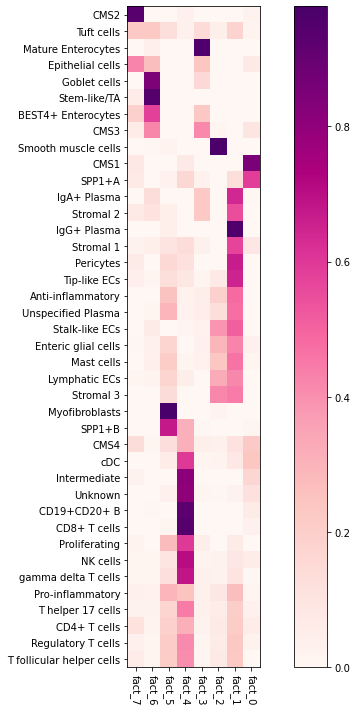

In [56]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

### R = 9

In [57]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(9)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 7870
init_2 - iterations until convergence: 6849
init_3 - iterations until convergence: 7126
init_4 - iterations until convergence: 8028
init_5 - iterations until convergence: 7557


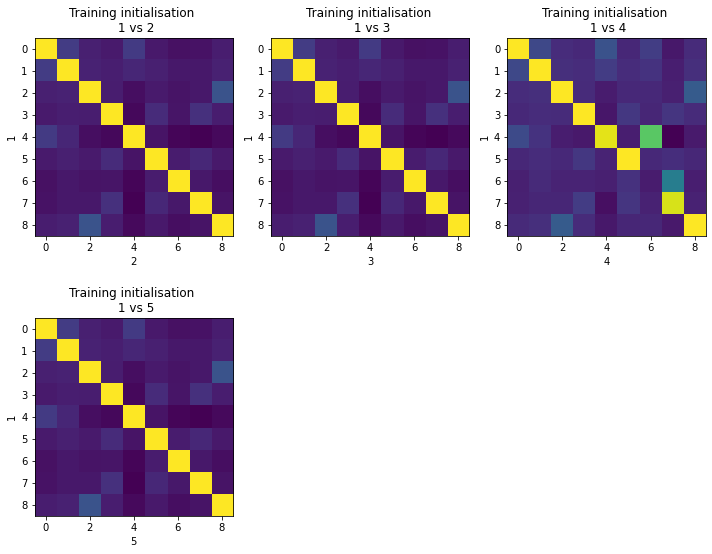

In [58]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

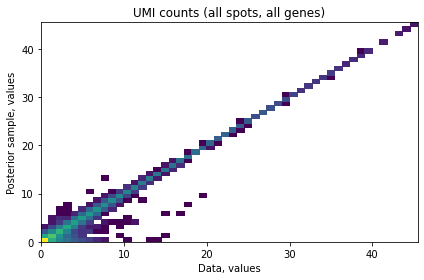

In [59]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [60]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0                 CMS2: 0.93   
mean_cell_type_factorsfact_1                 CMS1: 0.85   
mean_cell_type_factorsfact_2            Pericytes: 0.92   
mean_cell_type_factorsfact_3   Mature Enterocytes: 0.96   
mean_cell_type_factorsfact_4         CD19+CD20+ B: 0.93   
mean_cell_type_factorsfact_5         Stem-like/TA: 0.95   
mean_cell_type_factorsfact_6       Myofibroblasts: 0.97   
mean_cell_type_factorsfact_7  Smooth muscle cells: 0.96   
mean_cell_type_factorsfact_8          IgG+ Plasma: 0.96   

                                               top-2  \
mean_cell_type_factorsfact_0  Epithelial cells: 0.42   
mean_cell_type_factorsfact_1            SPP1+A: 0.46   
mean_cell_type_factorsfact_2      Tip-like ECs: 0.85   
mean_cell_type_factorsfact_3              CMS3: 0.41   
mean_cell_type_factorsfact_4      CD8+ T cells: 0.93   
mean_cell_type_factorsfact_5      Goblet cells: 0.85   
mean_cell_type_factorsfact_6            SPP1+B: 0.68   
mean_cell_type_factorsfact_7          Stromal 3: 0.4   
mean_cell_type_factorsfact_8       IgA+ Plasma: 0.52   

                                                 top-3  \
mean_cell_type_factorsfact_0           Tuft cells: 0.2   
mean_cell_type_factorsfact_1                 cDC: 0.22   
mean_cell_type_factorsfact_2           Stromal 1: 0.78   
mean_cell_type_factorsfact_3    Epithelial cells: 0.24   
mean_cell_type_factorsfact_4        Intermediate: 0.81   
mean_cell_type_factorsfact_5  BEST4+ Enterocytes: 0.58   
mean_cell_type_factorsfact_6  Unspecified Plasma: 0.26   
mean_cell_type_factorsfact_7      Stalk-like ECs: 0.35   
mean_cell_type_factorsfact_8           Stromal 3: 0.47   

                                                 top-4  \
mean_cell_type_factorsfact_0  BEST4+ Enterocytes: 0.18   
mean_cell_type_factorsfact_1                CMS4: 0.21   
mean_cell_type_factorsfact_2           Stromal 2: 0.74   
mean_cell_type_factorsfact_3  BEST4+ Enterocytes: 0.23   
mean_cell_type_factorsfact_4             Unknown: 0.79   
mean_cell_type_factorsfact_5                CMS3: 0.42   
mean_cell_type_factorsfact_6    Pro-inflammatory: 0.25   
mean_cell_type_factorsfact_7       Lymphatic ECs: 0.28   
mean_cell_type_factorsfact_8   Unspecified Plasma: 0.4   

                                                  top-5  \
mean_cell_type_factorsfact_0                 CMS4: 0.13   
mean_cell_type_factorsfact_1         Intermediate: 0.15   
mean_cell_type_factorsfact_2               SPP1+A: 0.43   
mean_cell_type_factorsfact_3           IgA+ Plasma: 0.2   
mean_cell_type_factorsfact_4             NK cells: 0.67   
mean_cell_type_factorsfact_5     Epithelial cells: 0.27   
mean_cell_type_factorsfact_6    Anti-inflammatory: 0.22   
mean_cell_type_factorsfact_7  Enteric glial cells: 0.27   
mean_cell_type_factorsfact_8    Anti-inflammatory: 0.38   

                                                  top-6  \
mean_cell_type_factorsfact_0        CD4+ T cells: 0.097   
mean_cell_type_factorsfact_1              Unknown: 0.11   
mean_cell_type_factorsfact_2        Lymphatic ECs: 0.26   
mean_cell_type_factorsfact_3         Goblet cells: 0.15   
mean_cell_type_factorsfact_4  gamma delta T cells: 0.65   
mean_cell_type_factorsfact_5           Tuft cells: 0.21   
mean_cell_type_factorsfact_6        Proliferating: 0.21   
mean_cell_type_factorsfact_7           Mast cells: 0.22   
mean_cell_type_factorsfact_8       Stalk-like ECs: 0.37   

                                                        top-7  \
mean_cell_type_factorsfact_0                      CMS1: 0.076   
mean_cell_type_factorsfact_1                      CMS3: 0.092   
mean_cell_type_factorsfact_2              Proliferating: 0.24   
mean_cell_type_factorsfact_3                 Tuft cells: 0.13   
mean_cell_type_factorsfact_4                        cDC: 0.58   
mean_cell_type_factorsfact_5                IgA+ Plasma: 0.12   
mean_cell_type_factorsfact_6  T follicular helper cells: 0.19   
mean_cell_type_factorsfact_7      

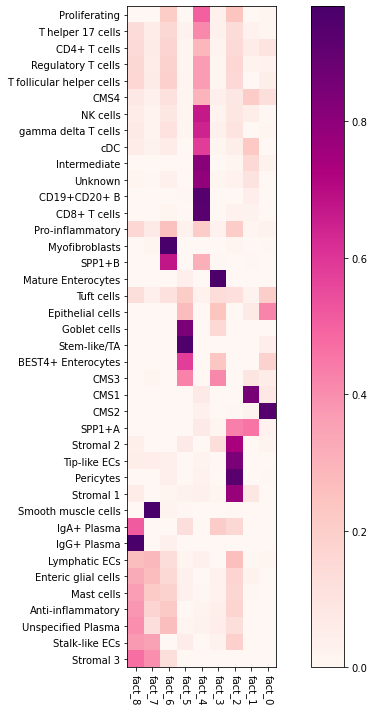

In [61]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

### R = 10

In [62]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(10)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 7620
init_2 - iterations until convergence: 6831
init_3 - iterations until convergence: 7262
init_4 - iterations until convergence: 6477
init_5 - iterations until convergence: 6281


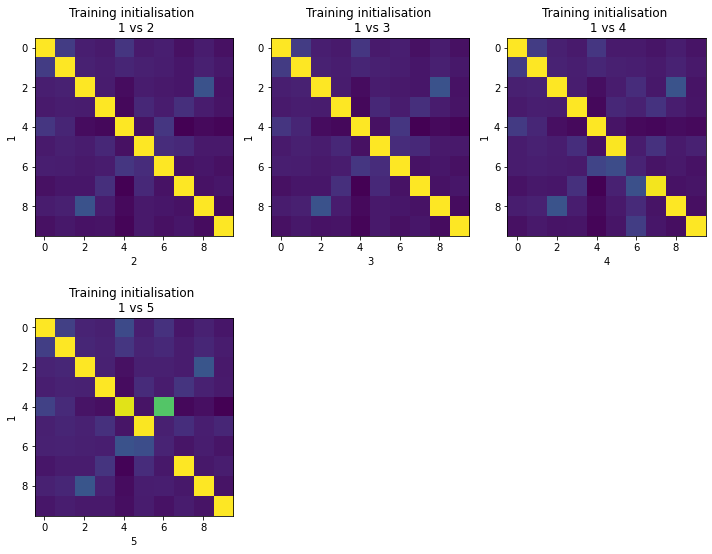

In [63]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

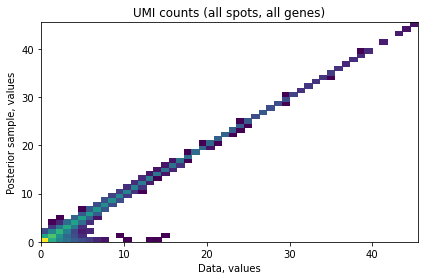

In [64]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [65]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0                  CMS2: 0.9   
mean_cell_type_factorsfact_1   Mature Enterocytes: 0.96   
mean_cell_type_factorsfact_2         CD8+ T cells: 0.82   
mean_cell_type_factorsfact_3            Pericytes: 0.92   
mean_cell_type_factorsfact_4         CD19+CD20+ B: 0.71   
mean_cell_type_factorsfact_5                 CMS1: 0.81   
mean_cell_type_factorsfact_6          IgG+ Plasma: 0.96   
mean_cell_type_factorsfact_7       Myofibroblasts: 0.97   
mean_cell_type_factorsfact_8  Smooth muscle cells: 0.96   
mean_cell_type_factorsfact_9         Stem-like/TA: 0.95   

                                              top-2                     top-3  \
mean_cell_type_factorsfact_0  Epithelial cells: 0.4          Tuft cells: 0.19   
mean_cell_type_factorsfact_1             CMS3: 0.41    Epithelial cells: 0.24   
mean_cell_type_factorsfact_2          Unknown: 0.69        Intermediate: 0.65   
mean_cell_type_factorsfact_3     Tip-like ECs: 0.84           Stromal 1: 0.76   
mean_cell_type_factorsfact_4              cDC: 0.29        Intermediate: 0.19   
mean_cell_type_factorsfact_5           SPP1+A: 0.44                 CMS4: 0.2   
mean_cell_type_factorsfact_6      IgA+ Plasma: 0.52           Stromal 3: 0.47   
mean_cell_type_factorsfact_7           SPP1+B: 0.64  Unspecified Plasma: 0.26   
mean_cell_type_factorsfact_8         Stromal 3: 0.4      Stalk-like ECs: 0.35   
mean_cell_type_factorsfact_9     Goblet cells: 0.85  BEST4+ Enterocytes: 0.59   

                                                        top-4  \
mean_cell_type_factorsfact_0         BEST4+ Enterocytes: 0.17   
mean_cell_type_factorsfact_1         BEST4+ Enterocytes: 0.23   
mean_cell_type_factorsfact_2                   NK cells: 0.61   
mean_cell_type_factorsfact_3                  Stromal 2: 0.74   
mean_cell_type_factorsfact_4  T follicular helper cells: 0.18   
mean_cell_type_factorsfact_5                        cDC: 0.18   
mean_cell_type_factorsfact_6          Unspecified Plasma: 0.4   
mean_cell_type_factorsfact_7           Pro-inflammatory: 0.24   
mean_cell_type_factorsfact_8              Lymphatic ECs: 0.27   
mean_cell_type_factorsfact_9                       CMS3: 0.42   

                                                  top-5  \
mean_cell_type_factorsfact_0                 CMS4: 0.11   
mean_cell_type_factorsfact_1           IgA+ Plasma: 0.2   
mean_cell_type_factorsfact_2   gamma delta T cells: 0.6   
mean_cell_type_factorsfact_3               SPP1+A: 0.42   
mean_cell_type_factorsfact_4              Unknown: 0.14   
mean_cell_type_factorsfact_5         Intermediate: 0.15   
mean_cell_type_factorsfact_6    Anti-inflammatory: 0.38   
mean_cell_type_factorsfact_7    Anti-inflammatory: 0.22   
mean_cell_type_factorsfact_8  Enteric glial cells: 0.26   
mean_cell_type_factorsfact_9     Epithelial cells: 0.27   

                                                 top-6  \
mean_cell_type_factorsfact_0       CD4+ T cells: 0.084   
mean_cell_type_factorsfact_1        Goblet cells: 0.15   
mean_cell_type_factorsfact_2       Proliferating: 0.57   
mean_cell_type_factorsfact_3       Lymphatic ECs: 0.25   
mean_cell_type_factorsfact_4  Regulatory T cells: 0.13   
mean_cell_type_factorsfact_5             Unknown: 0.11   
mean_cell_type_factorsfact_6      Stalk-like ECs: 0.37   
mean_cell_type_factorsfact_7        Proliferating: 0.2   
mean_cell_type_factorsfact_8          Mast cells: 0.21   
mean_cell_type_factorsfact_9          Tuft cells: 0.21   

                                                top-7  \
mean_cell_type_factorsfact_0              CMS1: 0.069   
mean_cell_type_factorsfact_1          Stromal 2: 0.13   
mean_cell_type_factorsfact_2                cDC: 0.39   
mean_cell_type_factorsfact_3   Pro-inflammatory: 0.19   
mean_cell_type_factorsfact_4  T helper 17 cells: 0.12   
mean_cell_type_factorsfact_5              CMS3: 0.099   
mean_cell_type_factorsfact_6         Mast cells: 0.36   
mean_cell_type_factorsfact_7         Mast cells

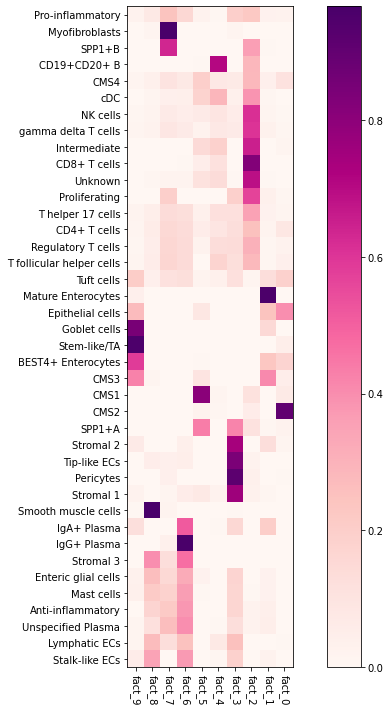

In [66]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

### R = 15

In [67]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(15)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 6266
init_2 - iterations until convergence: 4318
init_3 - iterations until convergence: 5905
init_4 - iterations until convergence: 4725
init_5 - iterations until convergence: 6271


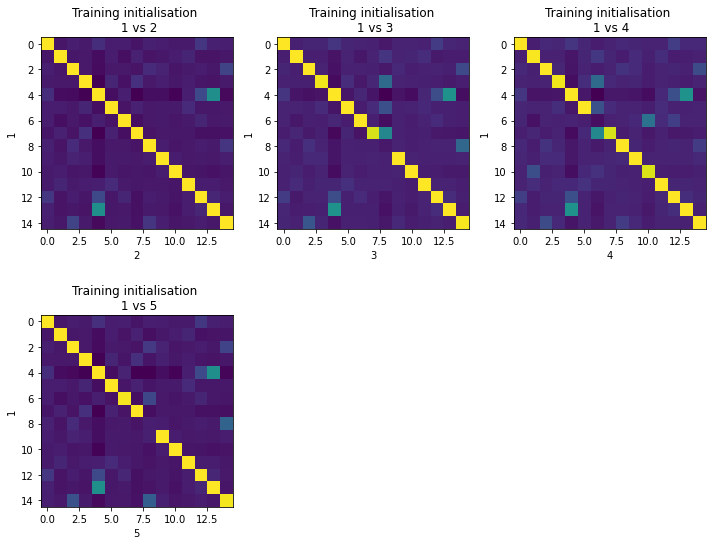

In [68]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

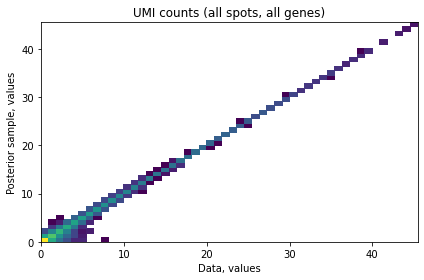

In [69]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [70]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0                SPP1+A: 0.87   
mean_cell_type_factorsfact_1          CD8+ T cells: 0.81   
mean_cell_type_factorsfact_2          CD19+CD20+ B: 0.66   
mean_cell_type_factorsfact_3                  CMS3: 0.94   
mean_cell_type_factorsfact_4    Mature Enterocytes: 0.93   
mean_cell_type_factorsfact_5                   CMS1: 0.8   
mean_cell_type_factorsfact_6          Stem-like/TA: 0.95   
mean_cell_type_factorsfact_7           IgA+ Plasma: 0.97   
mean_cell_type_factorsfact_8             Stromal 2: 0.93   
mean_cell_type_factorsfact_9                   CMS2: 0.9   
mean_cell_type_factorsfact_10                SPP1+B: 0.9   
mean_cell_type_factorsfact_11       Myofibroblasts: 0.96   
mean_cell_type_factorsfact_12  Smooth muscle cells: 0.95   
mean_cell_type_factorsfact_13          IgG+ Plasma: 0.98   
mean_cell_type_factorsfact_14             Pericytes: 0.9   

                                                  top-2  \
mean_cell_type_factorsfact_0            Stromal 1: 0.73   
mean_cell_type_factorsfact_1         Intermediate: 0.68   
mean_cell_type_factorsfact_2                  cDC: 0.24   
mean_cell_type_factorsfact_3     Epithelial cells: 0.64   
mean_cell_type_factorsfact_4         Goblet cells: 0.14   
mean_cell_type_factorsfact_5                 CMS4: 0.17   
mean_cell_type_factorsfact_6         Goblet cells: 0.78   
mean_cell_type_factorsfact_7       Stalk-like ECs: 0.18   
mean_cell_type_factorsfact_8        Proliferating: 0.35   
mean_cell_type_factorsfact_9           Tuft cells: 0.16   
mean_cell_type_factorsfact_10       Proliferating: 0.39   
mean_cell_type_factorsfact_11  Unspecified Plasma: 0.23   
mean_cell_type_factorsfact_12           Stromal 3: 0.39   
mean_cell_type_factorsfact_13            Stromal 3: 0.5   
mean_cell_type_factorsfact_14        Tip-like ECs: 0.84   

                                                  top-3  \
mean_cell_type_factorsfact_0    Epithelial cells: 0.082   
mean_cell_type_factorsfact_1              Unknown: 0.67   
mean_cell_type_factorsfact_2         Intermediate: 0.15   
mean_cell_type_factorsfact_3   BEST4+ Enterocytes: 0.38   
mean_cell_type_factorsfact_4   BEST4+ Enterocytes: 0.13   
mean_cell_type_factorsfact_5                  cDC: 0.16   
mean_cell_type_factorsfact_6   BEST4+ Enterocytes: 0.37   
mean_cell_type_factorsfact_7          Tuft cells: 0.059   
mean_cell_type_factorsfact_8    Anti-inflammatory: 0.24   
mean_cell_type_factorsfact_9     Epithelial cells: 0.15   
mean_cell_type_factorsfact_10   Pro-inflammatory: 0.084   
mean_cell_type_factorsfact_11    Pro-inflammatory: 0.18   
mean_cell_type_factorsfact_12      Stalk-like ECs: 0.29   
mean_cell_type_factorsfact_13  Unspecified Plasma: 0.36   
mean_cell_type_factorsfact_14      Stalk-like ECs: 0.19   

                                                         top-4  \
mean_cell_type_factorsfact_0               CD8+ T cells: 0.041   
mean_cell_type_factorsfact_1                    NK cells: 0.59   
mean_cell_type_factorsfact_2   T follicular helper cells: 0.15   
mean_cell_type_factorsfact_3         Enteric glial cells: 0.21   
mean_cell_type_factorsfact_4                 Tuft cells: 0.093   
mean_cell_type_factorsfact_5                Intermediate: 0.13   
mean_cell_type_factorsfact_6                  Tuft cells: 0.16   
mean_cell_type_factorsfact_7                 Mast cells: 0.056   
mean_cell_type_factorsfact_8            Pro-inflammatory: 0.17   
mean_cell_type_factorsfact_9          BEST4+ Enterocytes: 0.12   
mean_cell_type_factorsfact_10                        cDC: 0.05   
mean_cell_type_factorsfact_11          Anti-inflammatory: 0.16   
mean_cell_type_factorsfact_12              Lymphatic ECs: 0.24   
mean_cell_type_factorsfact_13          Anti-inflammatory: 0.31   
mean_cell_type_factorsfact_14              Lymphatic ECs: 0.18   

                                                   top-5  \
mean_cell_type_factorsfact_0    Regulatory T cells: 0.04   
mean_cell_type_factorsf

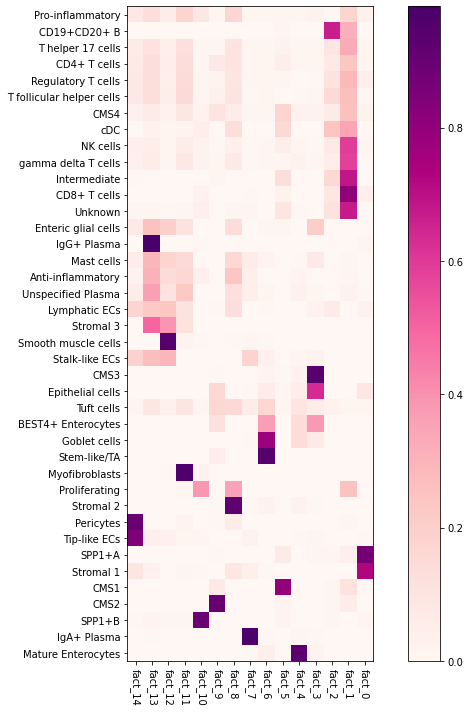

In [71]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

### R = 20

In [72]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(20)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 5277
init_2 - iterations until convergence: 5101
init_3 - iterations until convergence: 4603
init_4 - iterations until convergence: 5325
init_5 - iterations until convergence: 4612


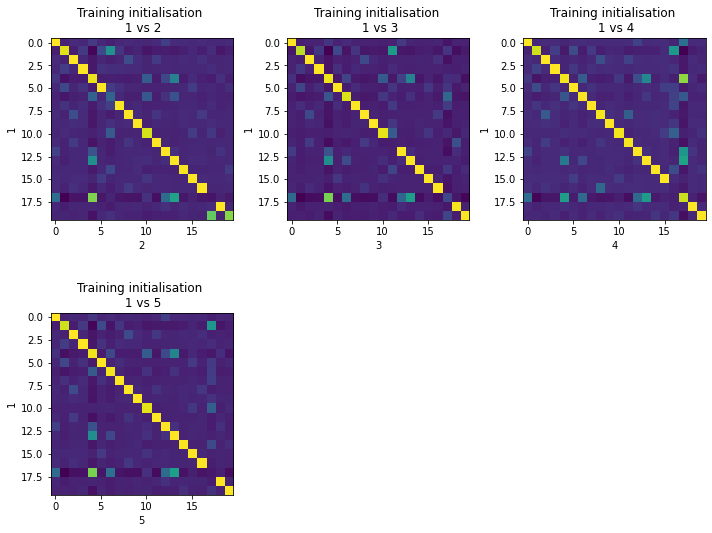

In [73]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

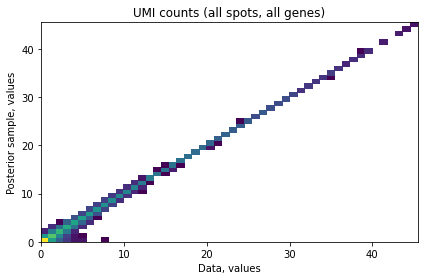

In [74]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [75]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0                   CMS2: 0.9   
mean_cell_type_factorsfact_1          CD8+ T cells: 0.78   
mean_cell_type_factorsfact_2                SPP1+B: 0.85   
mean_cell_type_factorsfact_3    Mature Enterocytes: 0.93   
mean_cell_type_factorsfact_4                SPP1+A: 0.87   
mean_cell_type_factorsfact_5                   cDC: 0.79   
mean_cell_type_factorsfact_6                  CMS3: 0.93   
mean_cell_type_factorsfact_7             Stromal 2: 0.92   
mean_cell_type_factorsfact_8          CD19+CD20+ B: 0.61   
mean_cell_type_factorsfact_9        Myofibroblasts: 0.88   
mean_cell_type_factorsfact_10    Anti-inflammatory: 0.79   
mean_cell_type_factorsfact_11            Pericytes: 0.88   
mean_cell_type_factorsfact_12         Goblet cells: 0.87   
mean_cell_type_factorsfact_13          IgG+ Plasma: 0.94   
mean_cell_type_factorsfact_14            Stromal 3: 0.89   
mean_cell_type_factorsfact_15        Proliferating: 0.87   
mean_cell_type_factorsfact_16                  CMS1: 0.8   
mean_cell_type_factorsfact_17         Stem-like/TA: 0.96   
mean_cell_type_factorsfact_18  Smooth muscle cells: 0.88   
mean_cell_type_factorsfact_19          IgA+ Plasma: 0.96   

                                                          top-2  \
mean_cell_type_factorsfact_0                   Tuft cells: 0.13   
mean_cell_type_factorsfact_1                 Intermediate: 0.65   
mean_cell_type_factorsfact_2            Pro-inflammatory: 0.034   
mean_cell_type_factorsfact_3           BEST4+ Enterocytes: 0.11   
mean_cell_type_factorsfact_4                    Stromal 1: 0.71   
mean_cell_type_factorsfact_5             Pro-inflammatory: 0.22   
mean_cell_type_factorsfact_6             Epithelial cells: 0.56   
mean_cell_type_factorsfact_7                   Tuft cells: 0.11   
mean_cell_type_factorsfact_8   T follicular helper cells: 0.096   
mean_cell_type_factorsfact_9           Unspecified Plasma: 0.16   
mean_cell_type_factorsfact_10               Lymphatic ECs: 0.33   
mean_cell_type_factorsfact_11                Tip-like ECs: 0.78   
mean_cell_type_factorsfact_12           BEST4+ Enterocytes: 0.4   
mean_cell_type_factorsfact_13          Unspecified Plasma: 0.21   
mean_cell_type_factorsfact_14              Stalk-like ECs: 0.47   
mean_cell_type_factorsfact_15                      Unknown: 0.1   
mean_cell_type_factorsfact_16                        CMS4: 0.13   
mean_cell_type_factorsfact_17            Epithelial cells: 0.18   
mean_cell_type_factorsfact_18               Lymphatic ECs: 0.15   
mean_cell_type_factorsfact_19              Stalk-like ECs: 0.13   

                                                         top-3  \
mean_cell_type_factorsfact_0            Epithelial cells: 0.12   
mean_cell_type_factorsfact_1                     Unknown: 0.57   
mean_cell_type_factorsfact_2              Proliferating: 0.028   
mean_cell_type_factorsfact_3               Goblet cells: 0.092   
mean_cell_type_factorsfact_4            Epithelial cells: 0.07   
mean_cell_type_factorsfact_5                        CMS4: 0.18   
mean_cell_type_factorsfact_6          BEST4+ Enterocytes: 0.36   
mean_cell_type_factorsfact_7                 Mast cells: 0.096   
mean_cell_type_factorsfact_8               Intermediate: 0.086   
mean_cell_type_factorsfact_9   T follicular helper cells: 0.11   
mean_cell_type_factorsfact_10         Unspecified Plasma: 0.28   
mean_cell_type_factorsfact_11              Lymphatic ECs: 0.12   
mean_cell_type_factorsfact_12                 Tuft cells: 0.13   
mean_cell_type_factorsfact_13                 Mast cells: 0.11   
mean_cell_type_factorsfact_14                 Mast cells: 0.25   
mean_cell_type_factorsfact_15              CD8+ T cells: 0.082   
mean_cell_type_factorsfact_16              Intermediate: 0.093   
mean_cell_type_factorsfact_17                Tuft cells: 0.049   
mean_cell_type_factorsfact_18       Enteric glial cells: 0.084   
mean_cell_type_factorsfact_19                Tuft cells: 0.048

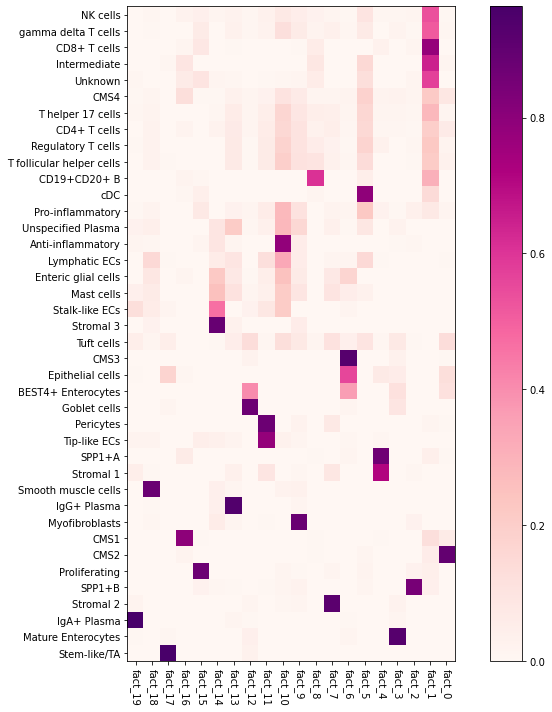

In [76]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])